<font size=10>**Assignment 5**

<font size=8>Introduction

<font size=4> 

Amorphous metals, commonly known as metallic glasses, are metals characterized by an irregular, non-repeating atomic structure, diverging from the typical crystalline arrangement found in most metallic materials(as can be seen in Figure 1). This structural deviation influences various mechanical, electrical, and magnetic properties, making metallic glasses highly sought-after in diverse industrial applications[1]. Despite challenges encountered in synthesizing these materials, a significant area of research pertains to predicting the compositions and conditions conducive to their formation[2]. Leveraging the capabilities of predictive machine learning (ML) methodologies allows for the approximation of glass-forming regions within incompletely explored compositional spaces.
<br>
<br>
<br>
<br>
<div style="text-align:center">
    <img src="https://www.metallurgyfordummies.com/wp-content/uploads/2011/07/amorphous-metal1.jpg" width="500"/>
<br>

Figure 1. Differences between metals and amorphous metals. Source : *Metallurgy for Dummies  : "Amorphous Metal"*

</div>
<br>
<br>
Due to their distinctive composition, metallic glasses exhibit discernible differences in X-ray diffraction (XRD) patterns when compared to crystalline metals [2]. The absence of sharp diffraction peaks, characteristic of well-ordered structures, and the presence of broad diffraction peaks define the XRD signature used for identification purposes [2]. Utilizing the maximum Full Width at Half Maximum (MaxFWHM)(Figure2) measurements of absorbance and establishing a threshold facilitate the identification of ternary compositions associated with glassy structures.
<br>
<br>
<br>
<br>
<div style="text-align:center">
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/FWHM.svg/1024px-FWHM.svg.png" width="500" align= "center"/>
<br>

Figure 2. Mathematical representation of the MaxFWHM area. Source : *Wikipedia : "Full width at half maximum"*
</div>
<br>
<br>

In this report, we aim to leverage existing absorption data from three distinct ternary systems to construct a comprehensive model of the combined quaternary system. This model will enable us to evaluate its glass-forming capabilities by leveraging previously identified amorphous regions. The methodology will involve the implementation of a multi-step feature evaluation workflow[3] optimized for *"using solely the features that are derived from chemical compositions of the materials data"* [3]. We will also compare the final ML against a heuristic for metalic glasses[4] to assess the accuracy and reliability of our predictive model.

<font size=4> 

**Methodology**
<br>
<br>
The workflow (Figure 3) outlined by the paper *"Automatic Prediction of Band Gaps of Inorganic Materials Using a Gradient Boosted and Statistical Feature Selection Workflow"* incorporates several steps to curate optimal features for classification and regression models using only composition as input data. This works well with our input data as it only contains the fractional composition of alloys in the ternary data and a classification of their glass formation. Due to time and hardware constraints, certain computational intensive steps and methods will be simplified for the purposes of this report.

<br>
<br>
<div style="text-align:center">

<img src="images_large_ci3c01897_0001.jpeg"/>
<br>
<br>

Figure 3. Proposed operational workflow. Source: *"Gradient boosted and statistical feature selection workflow for materials property predictions"[3][5]*
</div>

<font size=7>Code

**Modules**

In [2]:
#Loading dependencies
import scipy.io
import numpy.matlib as nm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pymatgen.core
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #stack overflow "https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning"
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

#Versions used
print(pd.__version__) #1.5.3
print(np.__version__) #1.26.4
print(scipy.__version__) #1.12.0
print(sklearn.__version__) #1.2.1
print(pymatgen.core.__version__) #2023.12.18

1.5.3
1.26.4
1.12.0
1.2.1
2023.12.18


<font size=6>**Importing data**

In [3]:
# Load data from CSV files
xls_file = pd.ExcelFile('Metallic Glass Data\Metallic Glass Data.xlsx') 

# Read data from different sheets
CrTiZr_data = xls_file.parse('CrTiZr')
CrCoZr_data = xls_file.parse('CrCoZr')
CoTiZr_data = xls_file.parse('CoTiZr')

#add a string of the elements in the compound
CrTiZr_data['comp_string'] = 'CrTiZr'
CrCoZr_data['comp_string'] = 'CrCoZr'
CoTiZr_data['comp_string'] = 'CoTiZr'

#Component list
components = ['Cr','Co','Ti','Zr']


**Merging Ternaries into a quaternary dataframe**

In [4]:
#extracting the FWHM data into one column  - Comp string will be used for cross validation later in the ropoer 
glass_temp= pd.concat([CrTiZr_data.pop('Glass (TRUE/FALSE)'), CrCoZr_data.pop('Glass (TRUE/FALSE)'), CoTiZr_data.pop('Glass (TRUE/FALSE)')],ignore_index=True)
comp_string_temp= pd.concat([CrTiZr_data.pop('comp_string'), CrCoZr_data.pop('comp_string'), CoTiZr_data.pop('comp_string')],ignore_index=True)

#Merging the three ternary dataframes
quaternary_data = pd.merge(CrTiZr_data,CrCoZr_data,on=['Cr','Zr'],how='outer')
quaternary_data = pd.merge(quaternary_data,CoTiZr_data, on=['Co','Ti', 'Zr'],how='outer')

#extracting labels for later use
column_labels_final = quaternary_data.columns

#merging the FWHM and composition dataframes
quaternary_data=pd.concat([quaternary_data,glass_temp],axis=1)

#filling the NaN values
quaternary_data = quaternary_data.fillna(0.0)
quaternary_data.head()

Cr        Ti        Zr   Co  Glass (TRUE/FALSE)
0  0.270945  0.480078  0.248976  0.0               False
1  0.196268  0.575674  0.228059  0.0               False
2  0.215384  0.550948  0.233668  0.0               False
3  0.235852  0.525511  0.238637  0.0               False
4  0.257642  0.499465  0.242892  0.0               False

**Basic Data Cleaning**

In [5]:
#taken from GPT 3.5

#find if any values are NaN
if quaternary_data.isnull().any().any():
    print("There are some NaN values in the dataframe\n")
else:
    print("There are no NaN values in the dataframe\n")

#Checking for Duplicates

#creating boolean duplicate dataframe
duplicates = quaternary_data.duplicated()

# Display rows with duplicates
print("Rows with duplicates:")
print(quaternary_data[duplicates])

# Display all duplicate rows
all_duplicates = quaternary_data[quaternary_data.duplicated(keep=False)]
print("\nAll duplicate rows:")
print(all_duplicates)

There are no NaN values in the dataframe

Rows with duplicates:
Empty DataFrame
Columns: [Cr, Ti, Zr, Co, Glass (TRUE/FALSE)]
Index: []

All duplicate rows:
Empty DataFrame
Columns: [Cr, Ti, Zr, Co, Glass (TRUE/FALSE)]
Index: []


<font size =6>

**Workflow step 1** - Featurization
</font>
<br>
<br>
Step 1 incorporates creating a matpygen composition object for each entry and creating features from the object. Due to time and computation constraints, a small subset of the total featurizers applied to composition objects used in the paper were used here.

In [6]:
#Conversion code modiffied from GPT 3.5 template
import pandas as pd
from pymatgen import core


# Apply the featurizer to each row of the DataFrame
compositions = []
for index, row in quaternary_data[components].iterrows():

    # Convert the row (elemental fractions) to a dictionary
    element_fractions = row.to_dict()
    
    # Convert the elemental fractions to a Pymatgen Composition object
    composition = core.Composition(element_fractions)
    
    # Append the features to the result list
    compositions.append(composition)
    

# Convert the result features list to a new DataFrame
compositions_df = pd.DataFrame(pd.Series(compositions,name='composition'))
quaternary_data_with_composition = pd.concat([quaternary_data, compositions_df],axis=1)


In [7]:
#Isolating target values
target_values = quaternary_data_with_composition.pop('Glass (TRUE/FALSE)')

**Featurizing**
<br>
We will use presets for the magpie and matminer featurizers to create features. We will also use the YangSolidSolution featurizer. There are many more featurizers that are used in the original workflow, including electronic and crystal structure featurizers, but will be omitted to reduce complexity.

In [8]:
from matminer.featurizers.composition import composite as comp
from matminer.featurizers.base import MultipleFeaturizer as MP
from matminer.featurizers.composition.alloy import YangSolidSolution

#Storing original column labels
column_labels = quaternary_data_with_composition.columns.tolist()

#Multiple featurizers - Taken from Paper[3] supplementary information - "https://github.com/Songyosk/BGML/blob/main/featurizers.py#L233" - Modified from the "generate_composition_features" method
composition_featurizer = MP([comp.ElementProperty.from_preset('magpie'),
                             YangSolidSolution(),
                             comp.ElementProperty.from_preset('matminer')
                            ])

features_df = composition_featurizer.featurize_dataframe(quaternary_data_with_composition,'composition',ignore_errors = True)


MultipleFeaturizer:   0%|          | 0/1323 [00:00<?, ?it/s]

**Data cleaning**

In [10]:
#isolating the compositon object column
comp_strings = pd.DataFrame(features_df.pop('composition'),columns=['composition'])

In [11]:
#Filling NaN values as 0 for instances where the featurizers were not able to calculate a value
features_df.fillna(0,inplace=True)

#removing all columns where all row values are the same
zero_columns = features_df.columns[features_df.var() == 0]
features_df = features_df.drop(zero_columns, axis=1)

print(f"The number of columns where all values are the same = {len(zero_columns)}")

The number of columns where all values are the same = 60


**Oversampling**
<br>
We want to avoid overrepresenting one of the groups (glass or non glass) for our traning data.

In [12]:
#Template taken from paper[3] and modified with help of GPT3.5

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_df, target_values, test_size=0.2, random_state=42)

# Check the class distribution in the training set
print("Class distribution before oversampling:", Counter(y_train))

# Check if oversampling is required
class_counts = Counter(y_train)
minority_class_count = min(class_counts.values())
majority_class_count = max(class_counts.values())
imbalance_ratio = majority_class_count / minority_class_count

if imbalance_ratio > 2:
    # Oversampling is required
    oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
    print("Class distribution after oversampling:", Counter(y_resampled))
    # Use X_resampled and y_resampled for training your model
else:
    # No oversampling required
    print("No oversampling required.")
    # Use X_train and y_train directly for training your model


Class distribution before oversampling: Counter({False: 608, True: 450})
No oversampling required.


<font size =6>

**Workflow step 2** - Gradient Boosted Feature Selection
</font>
<br>
<br>
Step 2 uses GBFS to create a separate set of feature importance metrics and values

**Gradient Boosting**
<br>
Grid search for optimal classifier

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Define the estimator
estimator = GradientBoostingClassifier()

# Define the hyperparameters grid
hyperparameters = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 4],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2]
}
# Create GridSearchCV object
grid_search = GridSearchCV(estimator, hyperparameters, cv=5, verbose=1, n_jobs=-1)

# Fit the data
# X_train, y_train: Your training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.9716623446302425


**Feature importance**
<br>
Reordering training data by feature importance of GFB

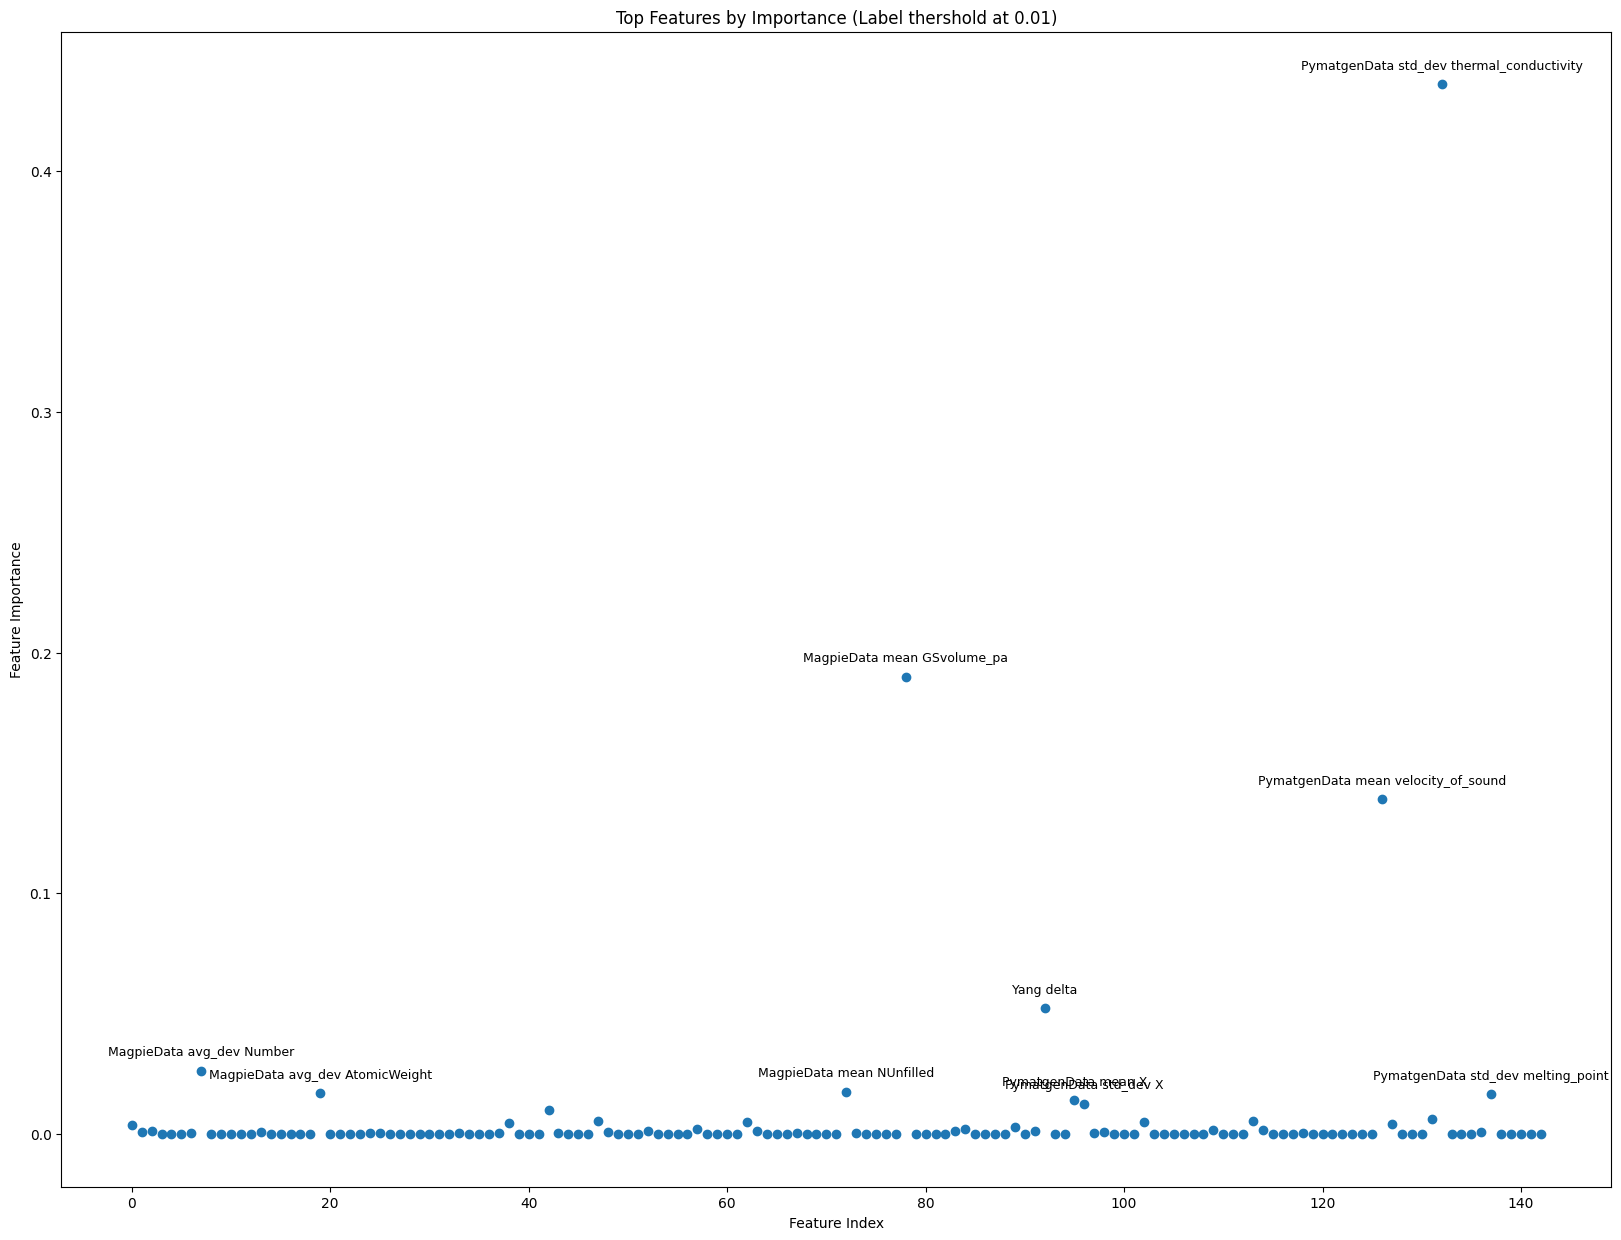

In [14]:
best_model = grid_search.best_estimator_

model_importance_array=best_model.feature_importances_

feature_labels = X_train.columns.tolist()
plt.figure(figsize=(20, 15))
label_offset = 0.005 # make the labels easier to read
for i, importance in enumerate(model_importance_array):
    if importance >= 0.01:
        plt.text(i, model_importance_array[i]+label_offset, feature_labels[i], fontsize=9, ha='center', va='bottom')

plt.scatter(range(len(model_importance_array)),model_importance_array)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Top Features by Importance (Label thershold at 0.01)')
plt.show()


In [15]:
feature_importances_with_names = list(zip(feature_labels, model_importance_array))

# Sort the feature importances by importance value in descending order
feature_importances_with_names.sort(key=lambda x: x[1], reverse=True)

# Extract feature names sorted by importance
sorted_feature_names = [f[0] for f in feature_importances_with_names]

# Reorder the columns of X_train based on sorted feature names
X_train_reordered = X_train[sorted_feature_names]
X_test_reordered = X_test[sorted_feature_names]


**Recursive Selection**
<br>
Assessment of model performace through feature subset fitting 

In [16]:
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, f1_score, hamming_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

# Assuming X_train_reordered and target_values are defined
# Define the range of features to consider (z)
z = range(1, len(model_importance_array) + 1)

# Initialize lists to store metrics
accuracy_list = []
auc_roc_list = []
average_precision_list = []
f1_list = []
hamming_loss_list = []

# Blank model with best hyperparameters
#Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}
gbm = GradientBoostingClassifier(**best_params)

for n in z:
    # Select top n features
    selected_features_train = X_train_reordered.iloc[:, :n]
    selected_features_test = X_test_reordered.iloc[:, :n]

    # Train model using selected features
    gbm.fit(selected_features_train, y_train)

    # Evaluate model performance on test set
    y_pred = gbm.predict(selected_features_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) == 2 else np.nan
    average_precision = average_precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    hamming_loss_avg = hamming_loss(y_test, y_pred)

    # Append metrics to respective lists
    accuracy_list.append(accuracy)
    auc_roc_list.append(auc_roc)
    average_precision_list.append(average_precision)
    f1_list.append(f1)
    hamming_loss_list.append(hamming_loss_avg)



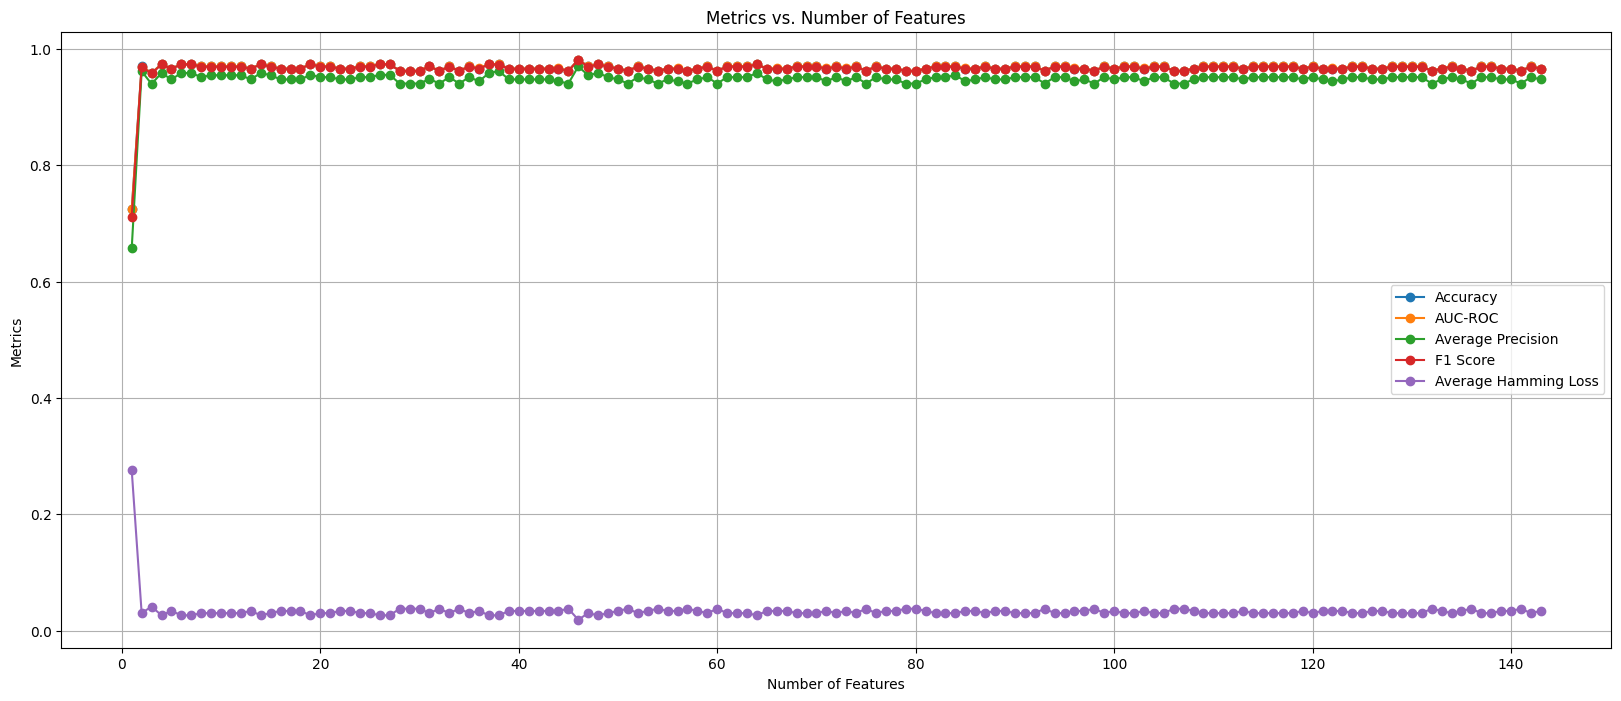

In [17]:

# Create multi-line plot for each metric
plt.figure(figsize=(20, 8))

plt.plot(z, accuracy_list, marker='o', label='Accuracy')
plt.plot(z, auc_roc_list, marker='o', label='AUC-ROC')
plt.plot(z, average_precision_list, marker='o', label='Average Precision')
plt.plot(z, f1_list, marker='o', label='F1 Score')
plt.plot(z, hamming_loss_list, marker='o', label='Average Hamming Loss')

plt.xlabel('Number of Features')
plt.ylabel('Metrics')
plt.title('Metrics vs. Number of Features')
plt.legend()
plt.grid(True)
plt.show()

The analysis of feature importance and recursive selection reveals that a concise set of features significantly impact the values related to glass formation. Notably, thermodynamic properties emerge as pivotal influencers, with a particular emphasis on thermal conductivity, which singularly contributes to nearly half of the feature importance. When combined with grain size, these properties collectively explain approximately 90% of the model's predictive performance. Beyond this point, there is a diminishing marginal contribution of additional features, indicating a saturation in their influence. This observation aligns with existing literature, underscoring the profound impact of thermodynamic properties on the potential formation of metallic glass.
Moving on, we will keep the features that are above 0.025 importance, which encapsulates 8 of the known features and seem to create the convergence line

In [18]:
n=8
X_train_reduced = X_train_reordered.iloc[:, :n]
X_test_reduced = X_test_reordered.iloc[:, :n]

<font size =6>

**Workflow step 3** - Statistical Analyses
</font>
<br>
<br>
Step 3 Performs statistical analysis on the subset of features we extracted from step 2. For this paper we will use logistic regression and ANOVA F-test measurements to provide statistically significant features for the model's decision-making process. The paper[3] also incorporates mutual information measurements as well as Chi squared scores, which have been omitted for simplicity. 

In [19]:
#code modified from Paper[3] supplemental information- https://github.com/Songyosk/BGML/blob/main/feature_analyses.py#L378
#Code organized by GPT3.5

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

#Extracting feature labels
features = X_train_reduced.columns.tolist()

# Scale features to ensure non-negative values
scaler = MinMaxScaler()
X_train_reduced_and_scaled = pd.DataFrame(scaler.fit_transform(X_train_reduced), columns=features)
X_train_reduced_and_scaled.index = y_train.index

X_test_reduced_and_scaled = pd.DataFrame(scaler.fit_transform(X_test_reduced), columns=features)
X_test_reduced_and_scaled.index = y_test.index


# Fit logistic regression model
logreg = LogisticRegression(multi_class='auto', max_iter=300, solver='liblinear') #Logistic regression for multivariate ranking - 'Liblinear' solver used as it is a binary classification problem
model = logreg.fit(X_train_reduced_and_scaled, y_train)

# Get coefficients and feature names
coefficients = model.coef_[0]
coefficients = [abs(i) for i in coefficients] #absolute importance
multivariate_ranking = pd.DataFrame(data=list(zip(features, coefficients)), columns=['feature_names', 'coefficient'])

# Sort features based on coefficients
multivariate_ranking_sorted = multivariate_ranking.sort_values(by='coefficient', ascending=False)

# Display the most significant features
top_log_features = multivariate_ranking_sorted
print("Top Significant Features based on Logistic Regression coefficients:")
print(top_log_features)

# Perform chi-squared test for feature selection
selector = SelectKBest(f_classif, k='all')
selector.fit(X_train_reduced_and_scaled, y_train)

# Get chi-squared scores and feature names
f_scores = selector.scores_

# Create DataFrame for F-statistic results
f_results = pd.DataFrame(data=list(zip(features, f_scores)), columns=['feature_names', 'f_score'])

# Sort features based on F-statistic scores
f_results_sorted = f_results.sort_values(by='f_score', ascending=False)

# Display top significant features based on F-statistic scores
top_f_features = f_results_sorted
print("\n\n\n"+"Top Significant Features based on F-statistic scores:")
print(top_f_features)

Top Significant Features based on Logistic Regression coefficients:
                               feature_names  coefficient
7         PymatgenData std_dev melting_point     4.706494
0  PymatgenData std_dev thermal_conductivity     4.386563
1                MagpieData mean GSvolume_pa     4.375192
3                                 Yang delta     3.565923
2        PymatgenData mean velocity_of_sound     2.159426
5                  MagpieData mean NUnfilled     0.927947
6            MagpieData avg_dev AtomicWeight     0.208001
4                  MagpieData avg_dev Number     0.136644



Top Significant Features based on F-statistic scores:
                               feature_names     f_score
0  PymatgenData std_dev thermal_conductivity  654.043189
7         PymatgenData std_dev melting_point  210.823507
2        PymatgenData mean velocity_of_sound  153.333748
3                                 Yang delta   67.055644
5                  MagpieData mean NUnfilled   40.202055
6          

The results show an agreement in rankings of importance across these two statistical models, with Velocity of sound and thermal conductivity being significant features. The most important feature from the last step is hown to be less impornat on f score. For the purposes of this report we will keep all the features as we move to the next step. With larger number of featrures and more statistical metrics for significance, it is possible to extract important features from this step as was done in the workflow paper while maintaining a relative large pool of features left[3].

<font size =6>

**Workflow step 4** - Feature Engineering
</font>
<br>
<br>
Step 4 Performs feature engineering on the features extracted from step 3. For the research paper, new features were created by the 'brute force method' of calculating the division of pairs for all possible permutations of features. There is great flexability of options on what features can be created and what interactions can be calculated between features. Due to computational complexity we will stick to a simple multiplication of features.

In [20]:
# Function to create new features. Other methods can be added to the function to increase possible features.
def create_engineered_features(df):
    original_features = list(df.columns)  # Store original feature names

    # Initialize an empty DataFrame to store new features
    new_df = pd.DataFrame()

    # Multiplication
    for i,col1 in enumerate(original_features):
        for col2 in original_features[i:]:
            if col1 != col2:
                new_col_name = f'{col1}_times_{col2}'
                new_df[new_col_name] = df[col1] * df[col2]
    df_concat = pd.concat([df, new_df], axis=1)
    return df_concat

# Apply feature engineering
X_train_engineered = create_engineered_features(X_train_reduced_and_scaled)
X_test_engineered = create_engineered_features(X_test_reduced_and_scaled)

<font size =6>

**Workflow step 5** - Multicollinearity Reduction
</font>
<br>
<br>
Step 5 Reduces the amount of features by performing a two step correlation analysis. First step creates a corrolation matrix and prunes based on a correlation threshold between features. thes econd step creats a hierchial clustering of the features and prunes the branching to fruther reduce the features.for simplicity we will use the simpler correlation matrix reduction.

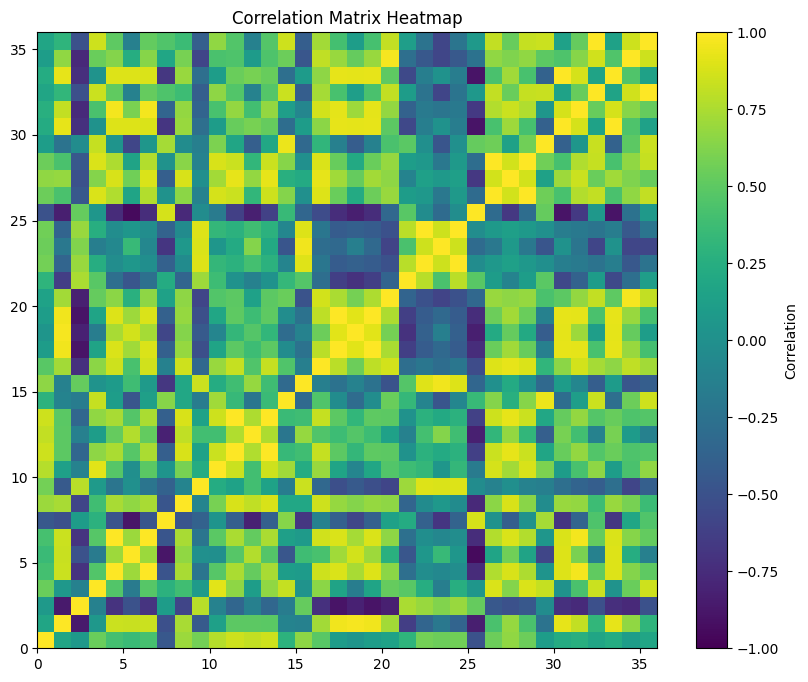

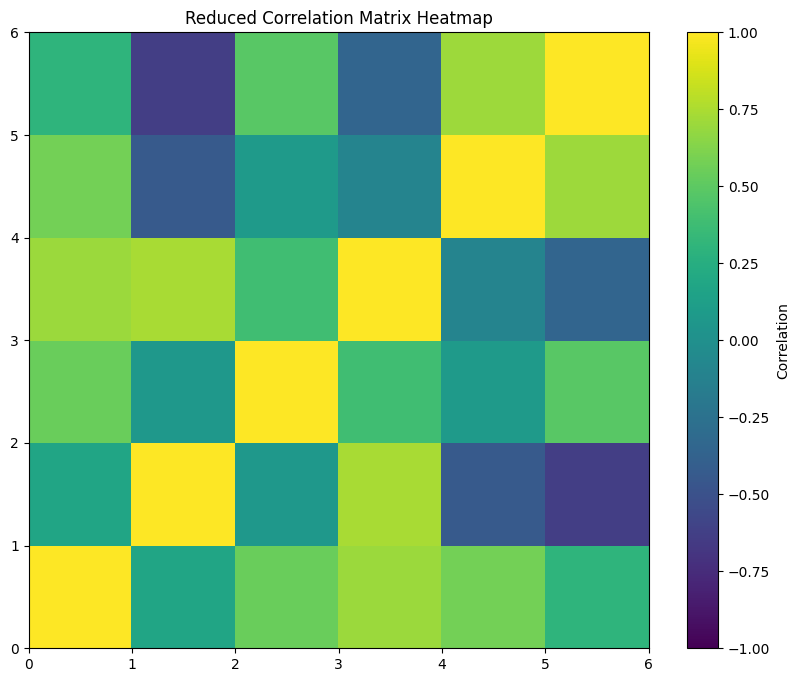

In [37]:
def plot_correlation_heatmap(corr_matrix,title):
    # Set up the matplotlib figure
    plt.figure(figsize=(10, 8))
    # Plot the heatmap
    heatmap = plt.pcolor(corr_matrix, cmap='viridis', vmin=-1, vmax=1)
    # Set plot title
    plt.title(title)
    #plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation='vertical')
    #plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
    plt.colorbar(heatmap, label='Correlation')
    # Show plot
    plt.show()

corr_matrix = X_train_engineered.corr()
plot_correlation_heatmap(corr_matrix,"Correlation Matrix Heatmap")
correlation_threshold = 0.8

# Find pairs of highly correlated columns
highly_correlated_columns = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
            colname = corr_matrix.columns[i]
            highly_correlated_columns.add(colname)

# Drop the highly correlated columns
X_train_no_hcorr = X_train_engineered.drop(columns=highly_correlated_columns)
X_test_no_hcorr = X_test_engineered.drop(columns=highly_correlated_columns)

corr_matrix_lean = X_train_no_hcorr.corr()
plot_correlation_heatmap(corr_matrix_lean,'Reduced Correlation Matrix Heatmap')

In [38]:
#Features left after reduction
print("Columns left post correlation reduction : \n")
for i in X_train_no_hcorr.columns.tolist():
    print(' - ' + i)

Columns left post correlation reduction : 

 - PymatgenData std_dev thermal_conductivity
 - MagpieData mean GSvolume_pa
 - Yang delta
 - PymatgenData std_dev thermal_conductivity_times_MagpieData mean GSvolume_pa
 - PymatgenData std_dev thermal_conductivity_times_PymatgenData mean velocity_of_sound
 - PymatgenData mean velocity_of_sound_times_Yang delta


<font size =6>

**Workflow step 6** - Recursive Feature Elimination
</font>
<br>
<br>
Step 6 Reduces the amount of features by performing a recursive feature elimination wih a ten fold cross-validation. 

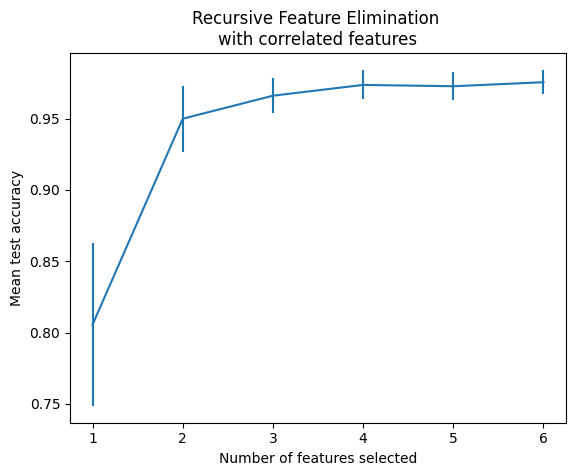

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt


# Create a Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=0)

# Initialize RFECV for 10-fold cross-validation
rfe_cv = RFECV(estimator=gb_classifier, step=1, cv=10, scoring='f1_weighted')

# Fit RFECV to the training data
rfe_cv.fit(X_train_no_hcorr, y_train)
#plotting
min_features_to_select = 1  
n_scores = len(rfe_cv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfe_cv.cv_results_["mean_test_score"],
    yerr=rfe_cv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [40]:
#final set of features- feature selection complete
selected_features = X_train_no_hcorr.iloc[:, rfe_cv.support_]
print('Remaning features:')
for i in selected_features.columns.tolist():
    print(' - ' + i)

Remaning features:
 - PymatgenData std_dev thermal_conductivity
 - MagpieData mean GSvolume_pa
 - Yang delta
 - PymatgenData std_dev thermal_conductivity_times_MagpieData mean GSvolume_pa
 - PymatgenData std_dev thermal_conductivity_times_PymatgenData mean velocity_of_sound
 - PymatgenData mean velocity_of_sound_times_Yang delta


The remaining features encapsulate features onsistent with the formation of the metallic glasses , with thermodynamic and structural features remaining important after multiple feature selection steps. 

<font size =6>

**Workflow step 7** - Optimization
</font>
<br>
<br>
Step 7 involves a grid seach of a hyperparameter space, where afterwards a baysean optamization is to be applied. This is used on the paper as it is an effective way to approximate an objective function that has no closed form and it is epxensive to evaluate[3]. The hyperparameter and rounds of optimization will be kept low due to computational complexity.

In [130]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

def optimize_hyperparameters(X, y,estimator,hyperparameters, problem='classification'):
    if problem == 'classification':
        scoring = make_scorer(f1_score, average='weighted')
    else:
        scoring = 'neg_root_mean_squared_error'
    
    # Perform Bayesian optimization
    opt = BayesSearchCV(
        estimator,
        hyperparameters,
        scoring=scoring,
        cv=5,
        n_iter=100,
        n_jobs=-1,
        random_state=42
    )
    opt.fit(X, y)
    # Get the best hyperparameters
    best_params = opt.best_params_
    best_score = opt.best_score_
    best_estimator = opt.best_estimator_
    results = opt.optimizer_results_
    
    return best_params,best_score,best_estimator,opt

Tunning - *LGBM Classifier*

In [131]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(
                        boosting_type='gbdt',
                        objective="binary",
                        random_state=42,
                        importance_type='gain',
                        max_depth=-1,
                        verbose=-1
                        )

hyperparameters = {
    'learning_rate': Real(0.01, 1.0, prior='log-uniform'),
    'n_estimators': Integer(100, 1000),
    'num_leaves': Integer(10, 100),
}

best_hyperparameters_LBGM,best_score_LBGM,best_estimator_LBGM,results_LBGM = optimize_hyperparameters(selected_features, y_train,model,hyperparameters)
print('Best Hyperparameters:', best_hyperparameters_LBGM)
print('Best score:', best_score_LBGM)
print('Best Estimator:',best_estimator_LBGM)

Best Hyperparameters: OrderedDict([('learning_rate', 0.6147087062857749), ('n_estimators', 101), ('num_leaves', 11)])
Best score: 0.5397533094276531
Best Estimator: LGBMClassifier(importance_type='gain', learning_rate=0.6147087062857749,
               n_estimators=101, num_leaves=11, objective='binary',
               random_state=42, verbose=-1)


Text(0, 0.5, 'min_samples_split')

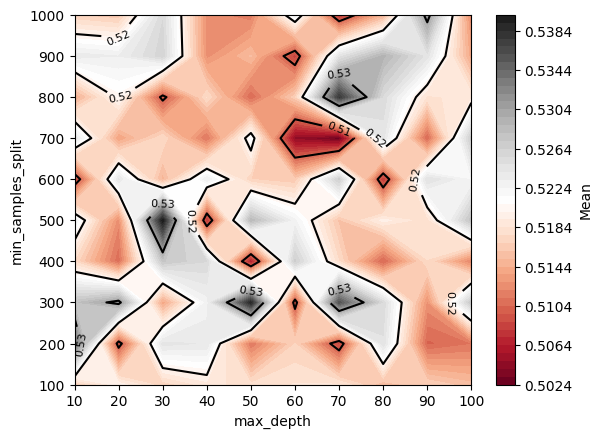

In [151]:
x = range(10,110,10)
y = range(100,1100,100)
z = results_LBGM.cv_results_['mean_test_score'].reshape(10,10)

X, Y = np.meshgrid(x, y)

plt.figure()
plt.contourf(X, Y, z, 50, cmap='RdGy')
plt.colorbar(label='Mean');

contours = plt.contour(X, Y, z, 3, colors='black')
plt.clabel(contours, inline=True, fontsize=8)

plt.xlabel('max_depth')
plt.ylabel('min_samples_split')

Tunning - *Logistic regression classifier*

In [154]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

hyperparameters = {
    'C': Real(1e-6, 1e+6, prior='log-uniform'),
    'penalty': Categorical(['l1', 'l2']),
    'solver': Categorical(['liblinear', 'saga'])
}
best_hyperparameters_LOGR,best_score_LOGR,best_estimator_LOGR,results_LOGR = optimize_hyperparameters(selected_features, y_train,model,hyperparameters)
print('Best Hyperparameters:', best_hyperparameters_LOGR)
print('Best score:', best_score_LOGR)
print('Best Estimator:',best_estimator_LOGR)

Best Hyperparameters: OrderedDict([('C', 165.07199750678976), ('penalty', 'l1'), ('solver', 'saga')])
Best score: 0.4448613209445657
Best Estimator: LogisticRegression(C=165.07199750678976, penalty='l1', solver='saga')


Tunning - *LDA*

In [47]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model = lda = LinearDiscriminantAnalysis()

hyperparameters = {
    'solver': Categorical(['lsqr', 'eigen']),
    'shrinkage': Real(0.0, 1.0),
    'tol': Real(1e-6, 1e-2, prior='log-uniform'),
}

best_hyperparameters_LDA,best_score_LDA,best_estimator_LDA,results_LDA = optimize_hyperparameters(selected_features, y_train,model,hyperparameters)
print('Best Hyperparameters:', best_hyperparameters_LDA)
print('Best score:', best_score_LDA)
print('Best Estimator:',best_estimator_LDA)

Best Hyperparameters: OrderedDict([('shrinkage', 0.001502271402568756), ('solver', 'lsqr'), ('tol', 0.007575483772025678)])
Best score: 0.9256112982583906
Best Estimator: LinearDiscriminantAnalysis(shrinkage=0.001502271402568756, solver='lsqr',
                           tol=0.007575483772025678)


**Final Models**
<br>
We now have the hyperparameters and the optimal features for predicting glass formation using various ML classification architectures. We can now proceed with the evaluation and full system predictions.

In [49]:
Final_Models = [best_estimator_LBGM,best_estimator_LOGR,best_estimator_LDA]
for model in Final_Models:
    print(model)
    print('\n')

LGBMClassifier(importance_type='gain', learning_rate=0.0239035238177249,
               n_estimators=161, num_leaves=13, objective='binary',
               random_state=42, verbose=-1)


LogisticRegression(C=5607.275056505338, penalty='l1', solver='saga')


LinearDiscriminantAnalysis(shrinkage=0.001502271402568756, solver='lsqr',
                           tol=0.007575483772025678)




<font size=6>**Cross Validation**

We will now evaluate the model using a standard cross validation method as well as a group omission validation to test the robustness of the features used. 

Remaning features:
 - PymatgenData std_dev thermal_conductivity
 - MagpieData mean GSvolume_pa
 - Yang delta
 - PymatgenData std_dev thermal_conductivity_times_MagpieData mean GSvolume_pa
 - PymatgenData std_dev thermal_conductivity_times_PymatgenData mean velocity_of_sound
 - PymatgenData mean velocity_of_sound_times_Yang delta

**Re-featurizing the full dataset**

In [54]:
from matminer.featurizers.composition.composite import ElementProperty
from matminer.featurizers.base import MultipleFeaturizer
def final_features(final_df):
    # Define the featurizers for each feature
    pymatgen_std_dev_thermal_conductivity = ElementProperty(data_source='pymatgen', features=['thermal_conductivity'], stats=['std_dev'])
    magpie_mean_GSvolume_pa = ElementProperty(data_source='magpie', features=['GSvolume_pa'], stats=['mean'])
    yang_delta = YangSolidSolution()
    pymatgen_mean_velocity_of_sound = ElementProperty(data_source='pymatgen', features=['velocity_of_sound'], stats=['mean'])



    # Create the MultipleFeaturizer object and add the defined featurizers
    MF_final = MultipleFeaturizer([
        pymatgen_std_dev_thermal_conductivity,
        magpie_mean_GSvolume_pa,
        yang_delta,
        pymatgen_mean_velocity_of_sound,
        ])

    #Creating final feature dataset
    final_df = MF_final.featurize_dataframe(final_df,'composition',ignore_errors = True)

    pairs = [('PymatgenData std_dev thermal_conductivity','MagpieData mean GSvolume_pa'),('PymatgenData std_dev thermal_conductivity','PymatgenData mean velocity_of_sound'),('PymatgenData mean velocity_of_sound','Yang delta')]
    for col1,col2 in pairs:
        new_col_name = f'{col1}_times_{col2}'
        final_df[new_col_name] = final_df[col1] * final_df[col2]
    names = ['PymatgenData mean velocity_of_sound','Yang omega']
    final_df = final_df.drop(columns=names)
    return final_df
final_df = final_features(comp_strings)

MultipleFeaturizer:   0%|          | 0/1323 [00:00<?, ?it/s]

In [55]:
final_df

composition  PymatgenData std_dev thermal_conductivity  \
0     (Cr, Ti, Zr)                                  39.997833   
1     (Cr, Ti, Zr)                                  37.467250   
2     (Cr, Ti, Zr)                                  38.201511   
3     (Cr, Ti, Zr)                                  38.929362   
4     (Cr, Ti, Zr)                                  39.647040   
...            ...                                        ...   
1318  (Co, Ti, Zr)                                  50.601241   
1319  (Co, Ti, Zr)                                  50.718980   
1320  (Co, Ti, Zr)                                  50.835185   
1321  (Co, Ti, Zr)                                  50.949718   
1322  (Co, Ti, Zr)                                  50.967250   

      MagpieData mean GSvolume_pa  Yang delta  \
0                       16.819392    0.070834   
1                       17.094050    0.064330   
2                       17.025398    0.066087   
3                       16.945144    0.067833   
4                       16.852983    0.069556   
...                           ...         ...   
1318                    15.794556    0.110602   
1319                    15.850553    0.111007   
1320                    15.908901    0.111382   
1321                    15.969584    0.111727   
1322                    15.338031    0.110073   

      PymatgenData std_dev thermal_conductivity_times_MagpieData mean GSvolume_pa  \
0                                            672.739252                             
1                                            640.467054                             
2                                            650.395941                             
3                                            659.663641                             
4                                            668.170874                             
...                                                 ...                             
1318                                         799.224150                             
1319                                         803.923891                             
1320                                         808.731956                             
1321                                         813.645815                             
1322                                         781.737270                             

      PymatgenData std_dev thermal_conductivity_times_PymatgenData mean velocity_of_sound  \
0                                         181712.138644                                     
1                                         165445.695310                                     
2                                         169929.658343                                     
3                                         174535.798116                                     
4                                         179251.111436                                     
...                                                 ...                                     
1318                                      218207.993520                                     
1319                                      218550.296512                                     
1320                                      218874.923305                                     
1321                                      219181.374101                                     
1322                                      221451.310063                                     

      PymatgenData mean velocity_of_sound_times_Yang delta  
0                                            321.801920     
1                                            284.062487     
2                                            293.969595     
3                                            304.124108     
4                                            314.475643     
...                                                 ...     
1318                                         476.951457     
1319       

In [56]:
#droping composition column
final_df=final_df.drop(columns='composition')

**Cross Validation - *Random***
<br>
A simple 10 fold cross validation to measure accuracy of the final model

In [58]:
from sklearn.model_selection import train_test_split, cross_validate 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

#scoring
scoring_metrics = ['accuracy']

#splits
X_train, X_test, y_train, y_test = train_test_split(final_df, target_values, test_size=0.2, random_state=0)

#scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#cv
for model in Final_Models:
    cv_results = cross_validate(model, X_train_scaled, y_train, cv=10, scoring=scoring_metrics)
    print(model)
    print("Fold scores (accuracy):")
    for j,k in enumerate(cv_results['test_accuracy']):
        print(f'fold {j+1} : {k}')


LGBMClassifier(importance_type='gain', learning_rate=0.0239035238177249,
               n_estimators=161, num_leaves=13, objective='binary',
               random_state=42, verbose=-1)
Fold scores (accuracy):
fold 1 : 0.9622641509433962
fold 2 : 0.9716981132075472
fold 3 : 0.9528301886792453
fold 4 : 0.9622641509433962
fold 5 : 1.0
fold 6 : 0.9528301886792453
fold 7 : 0.9622641509433962
fold 8 : 0.9905660377358491
fold 9 : 0.9809523809523809
fold 10 : 0.9714285714285714
LogisticRegression(C=5607.275056505338, penalty='l1', solver='saga')
Fold scores (accuracy):
fold 1 : 0.9150943396226415
fold 2 : 0.9245283018867925
fold 3 : 0.8962264150943396
fold 4 : 0.8679245283018868
fold 5 : 0.9150943396226415
fold 6 : 0.8962264150943396
fold 7 : 0.9716981132075472
fold 8 : 0.9245283018867925
fold 9 : 0.9238095238095239
fold 10 : 0.8857142857142857
LinearDiscriminantAnalysis(shrinkage=0.001502271402568756, solver='lsqr',
                           tol=0.007575483772025678)
Fold scores (accuracy):


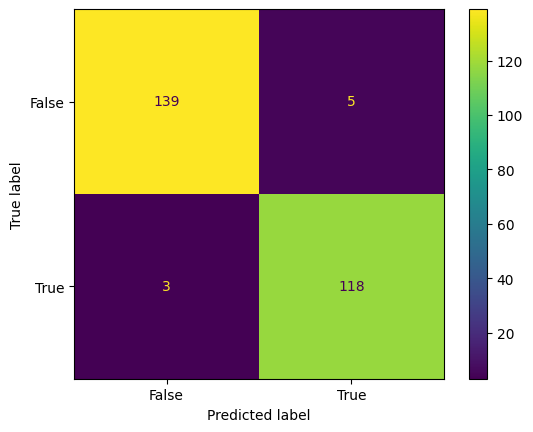

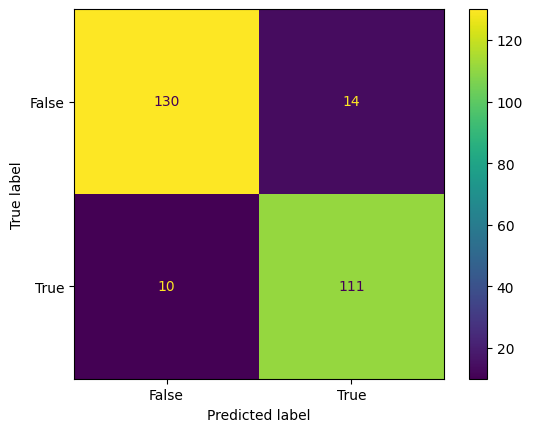

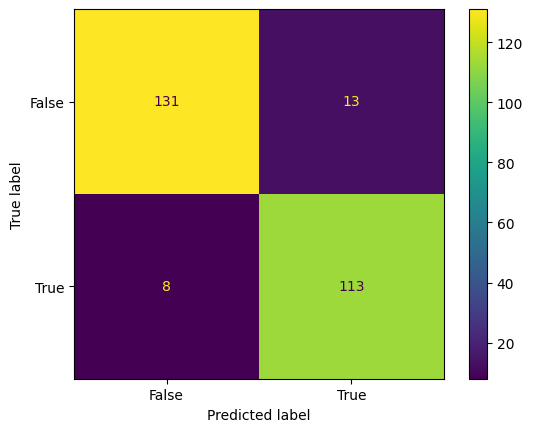

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for model in Final_Models:
    model.fit(X_train_scaled,y_train)
    y_predicted = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test,y_predicted,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot()
    plt.show()

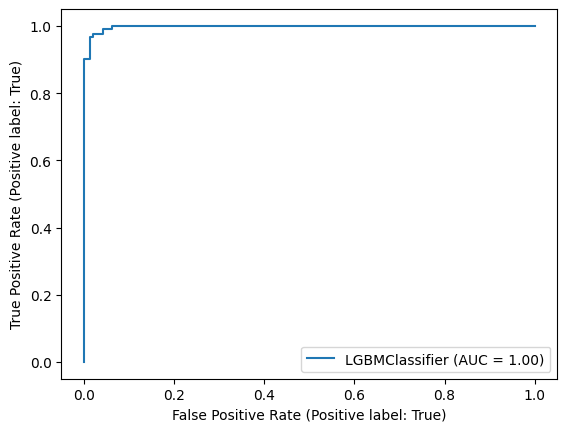

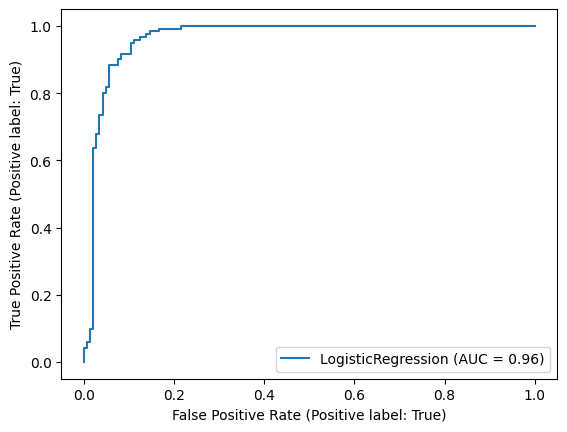

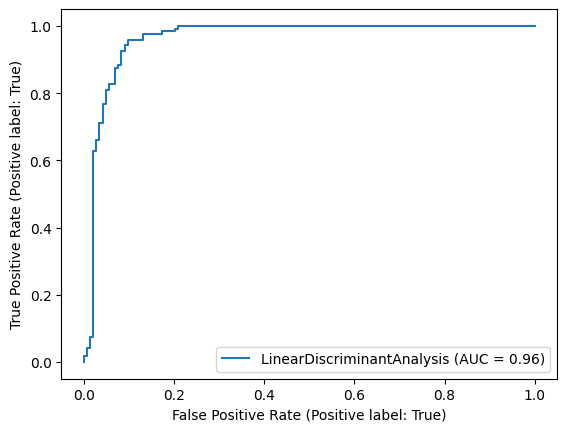

In [60]:
from sklearn.metrics import RocCurveDisplay
for model in Final_Models:
    RocCurveDisplay.from_estimator(model,X_test_scaled,y_test)
    plt.show()


The ROC curve and the confusion matrix indicate a high level of accuracy for the model, able to maintain a strong predictive capablity with test data.

**Cross Validation - *Leave one cluster out (LOCO)***
<br>
Testing the predictability of the model with missing information (ternary data)

In [61]:
#creating a index map of where certain compositions are found
elements = ['Cr',#will represent 'CoTiZr'
            'Co',#will represent 'CrTiZr'
            'Ti']#will represent 'CrCoZr'
#creating a matrix
element_id={}
for i in elements:
    element_id[i] = quaternary_data[i] == 0
#element_id identifies where there are no values for a certain element. ie represents the ternary missing that element

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import StandardScaler

#creating a function for evaluating Loco CV for a dataframe using composition folds
element_map = {'Cr': 'CoTiZr','Co': 'CrTiZr','Ti': 'CrCoZr'}
def loco_CV_comp(model,elements,element_id,X,Y):
    #split data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    
    #initate scaler
    scaler=StandardScaler(with_mean=True,with_std=True)

    #scaling the training set
    column_labels = X_train.columns.tolist()
    row_labels = X_train.index.tolist()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled,index=row_labels, columns=column_labels)

    #scaling the test set
    column_labels = X_test.columns.tolist()
    row_labels = X_test.index.tolist()
    X_test_scaled = scaler.transform(X_test)
    X_test_scaled = pd.DataFrame(X_test_scaled,index=row_labels, columns=column_labels)


    results = {}

    #loco cv loop for each ternary
    for element in elements:
        #fit model
        model.fit(X_train_scaled.loc[~element_id[element]],y_train.loc[~element_id[element]])
            
        # Predict the target variable for the test set
        y_pred=model.predict(X_test_scaled)

        #confusion matrix for fold
        cm = confusion_matrix(y_test,y_pred,labels=model.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
        disp.plot()
        plt.title(f'Confusion matrix for model trained without {element_map[element]} ternary data')
        plt.show()
    return


LGBMClassifier(importance_type='gain', learning_rate=0.0239035238177249,
               n_estimators=161, num_leaves=13, objective='binary',
               random_state=42, verbose=-1)


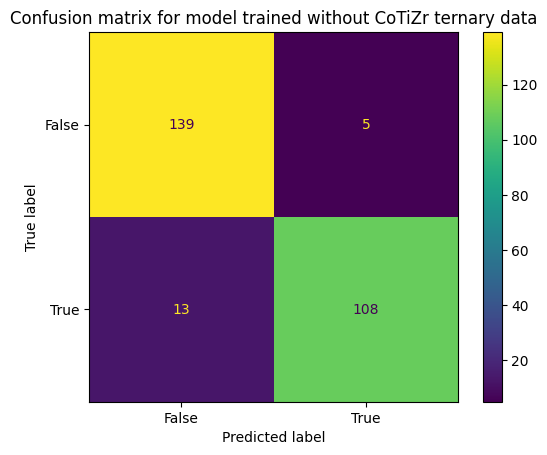

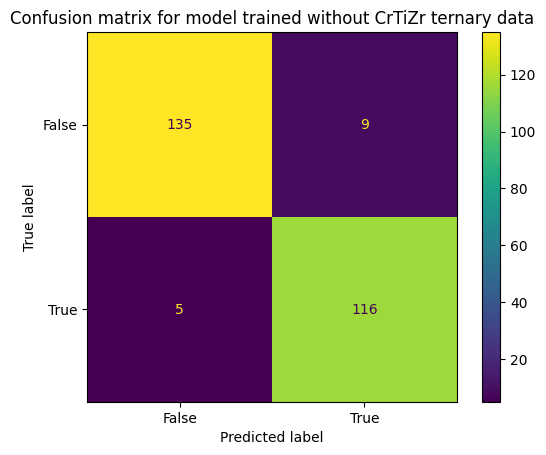

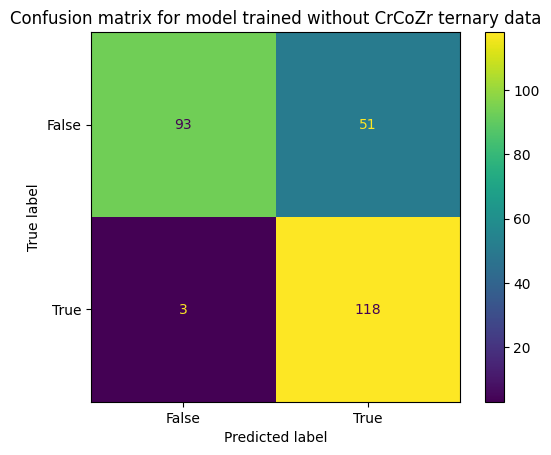

LogisticRegression(C=5607.275056505338, penalty='l1', solver='saga')


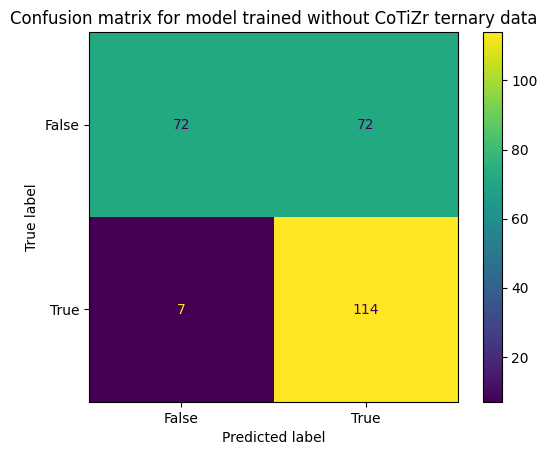

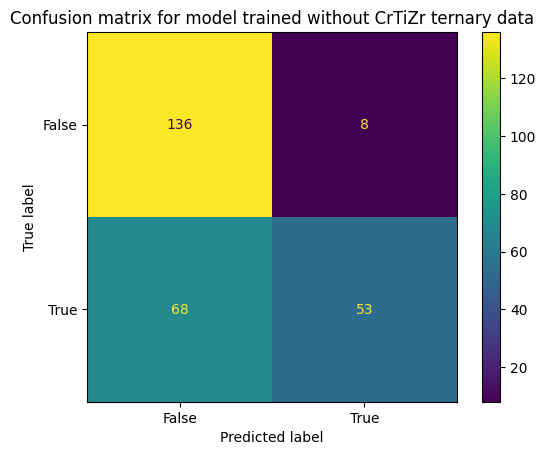

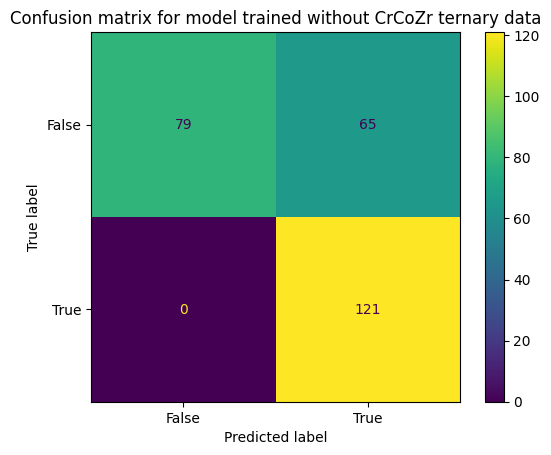

LinearDiscriminantAnalysis(shrinkage=0.001502271402568756, solver='lsqr',
                           tol=0.007575483772025678)


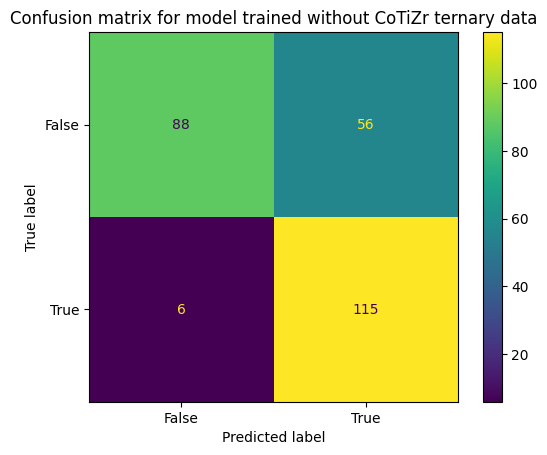

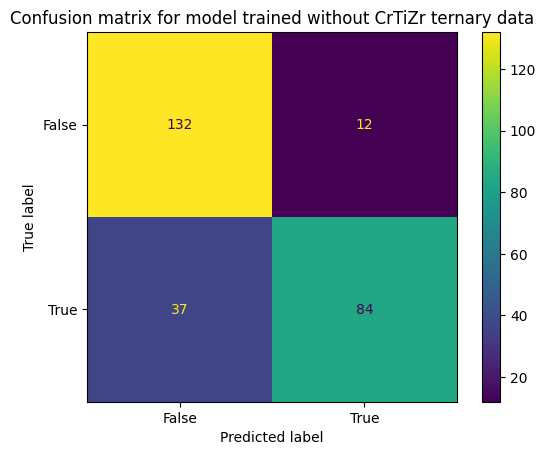

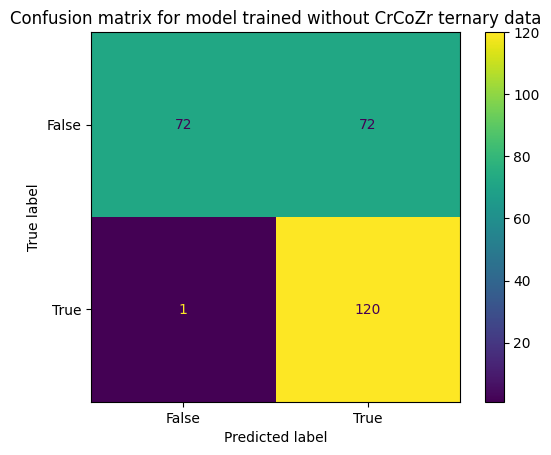

In [66]:
for model in Final_Models:
    print(model)    
    loco_CV_comp(model,elements,element_id,final_df,target_values)


The model accuracy diminished slightly when it was trained without one of the three systems. Even without the data of one ternary, the model performs reasonably well being trained on the other two,proving the capability of the feature selection workflow.

<font size = 6>**Full data model**

We will now use the full quaternary system data to train the model and approximate the quaternary system and its glass forming regions.

LGBMClassifier(importance_type='gain', learning_rate=0.0239035238177249,
               n_estimators=161, num_leaves=13, objective='binary',
               random_state=42, verbose=-1)


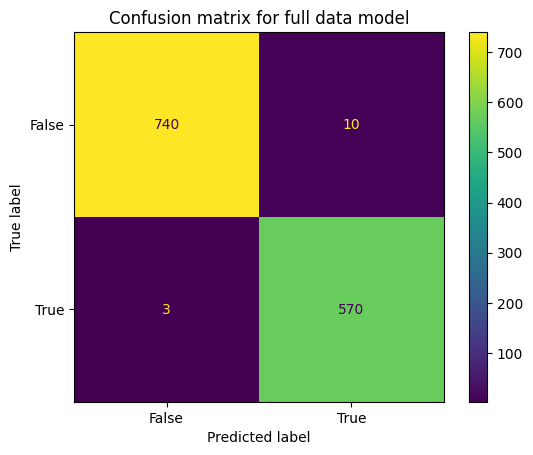

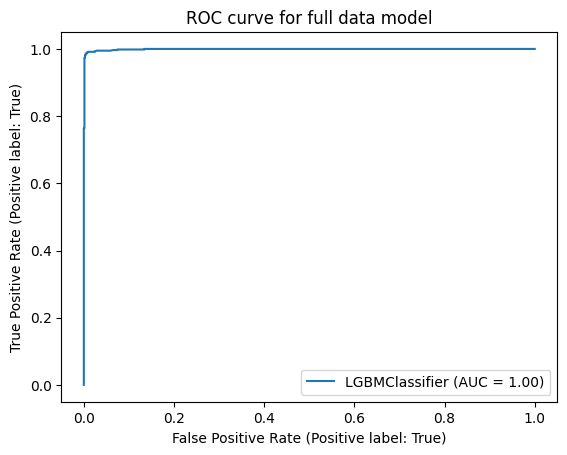

LogisticRegression(C=5607.275056505338, penalty='l1', solver='saga')


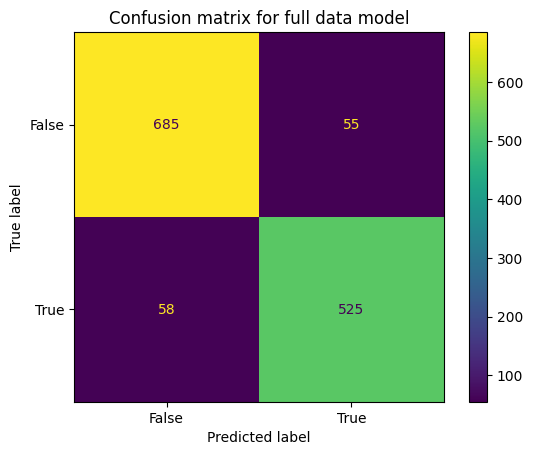

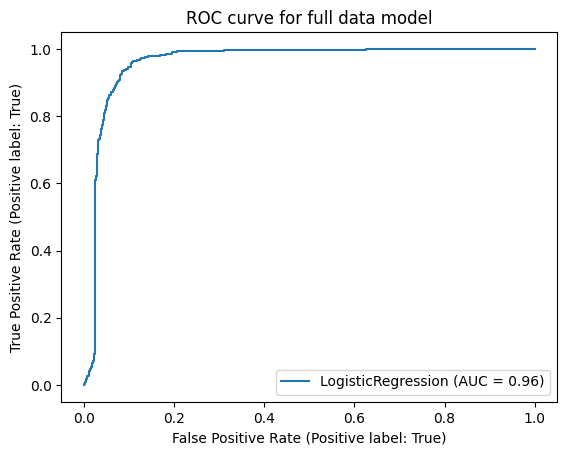

LinearDiscriminantAnalysis(shrinkage=0.001502271402568756, solver='lsqr',
                           tol=0.007575483772025678)


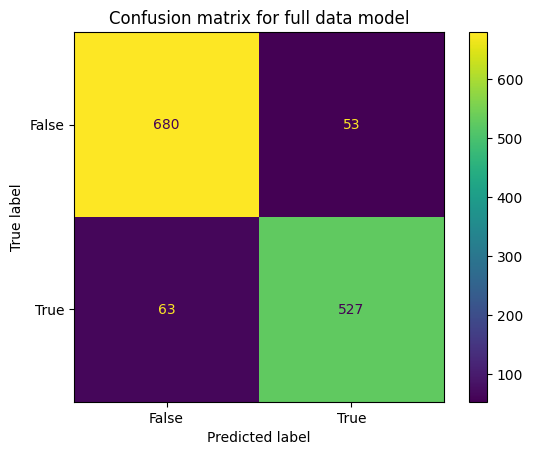

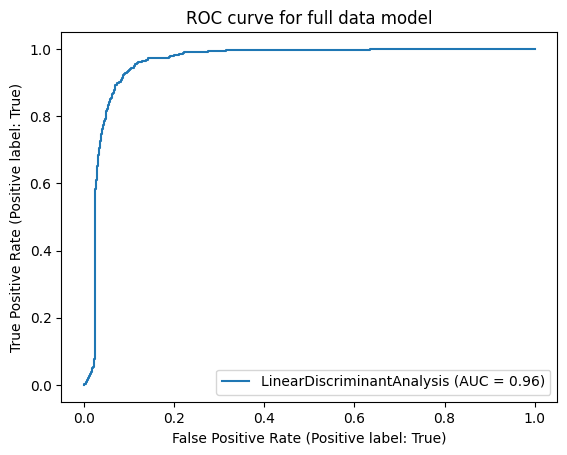

In [117]:
#initate scaler
scaler=StandardScaler(with_mean=True,with_std=True)

#scaling the full dataset
column_labels = final_df.columns.tolist()
final_df_scaled = scaler.fit_transform(final_df)
final_df_scaled = pd.DataFrame(final_df_scaled,columns=column_labels)

final_predictions= []
final_prediction_probability = []

for model in Final_Models:
    #fitting the model
    model.fit(final_df_scaled,target_values)

    #final predictions
    final_prediction = model.predict(final_df_scaled)
    final_prediction_probabilities = model.predict_proba(final_df_scaled)
    final_prediction_probabilities=final_prediction_probabilities[:, 1]
    
    #append to array
    final_predictions.append(final_prediction)
    final_prediction_probability.append(final_prediction_probabilities)

    print(model)

    #confusion matrix
    cm = confusion_matrix(final_prediction,target_values,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot()
    plt.title(f'Confusion matrix for full data model')
    plt.show()

    #ROC Curve
    RocCurveDisplay.from_estimator(model,final_df_scaled,target_values)
    plt.title(f'ROC curve for full data model')
    plt.show()


With a full data set model it becomes more clear that the model may be prone to overfitting.

**Full system predictions**

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#taken from ternary module documentation (under the helpers folder)
def simplex_iterator_to_dataframe(scale, boundary=True):
    start = 0
    if not boundary:
        start = 1
    
    result_list = []

    for i in range(start, scale + (1 - start)):
        for j in range(start, scale + (1 - start) - i):
            for k in range(start, scale + (1 - start) - i - j):
                l = scale - i - j - k
                result_list.append((i, j, k, l))
                
    # Convert the list of tuples to a DataFrame
    df = pd.DataFrame(result_list, columns=['i', 'j', 'k', 'l'])
    
    # Add a column with coordinate values
    #df['value'] = df['i'] + df['j'] + df['k'] + df['l']
    df=df/scale
    return df

# Example usage:
result_dataframe = simplex_iterator_to_dataframe(20)

#making result dataframe compatile with tetahedron function
result_dataframe = result_dataframe.values.tolist()

In [70]:
formula = 'Cr'+result_dataframe['i'].astype(str)+'Ti'+result_dataframe['j'].astype(str)+'Zr'+result_dataframe['k'].astype(str)+'Co'+result_dataframe['l'].astype(str)
formula = formula.to_frame('formula')
df = pd.concat([result_dataframe, formula],axis=1)

In [71]:
from matminer.featurizers.conversions import StrToComposition

#convert the formula from a string into chemical composition
df2 = StrToComposition().featurize_dataframe(df, "formula")

StrToComposition:   0%|          | 0/1771 [00:00<?, ?it/s]

In [73]:
Compositions=df2['composition'].to_frame()
full_system_df = final_features(Compositions)
#dropping composition column
full_system_df = full_system_df.drop(columns='composition')

MultipleFeaturizer:   0%|          | 0/1771 [00:00<?, ?it/s]

In [96]:
#scaling using previously defined scaler
column_labels = full_system_df.columns.tolist()
full_system_df_scaled = scaler.fit_transform(full_system_df)
full_system_df_scaled = pd.DataFrame(full_system_df_scaled,columns=column_labels)

full_model_predictions = []
full_model_predictions_probabilites = []
for model in Final_Models:
    #making predictions for the entire system
    full_predictions = model.predict(full_system_df_scaled)
    final_predictions_probabilities = model.predict_proba(full_system_df_scaled)
    final_predictions_probabilities=final_predictions_probabilities[:, 1]

    #appending results
    full_model_predictions.append(full_predictions)
    full_model_predictions_probabilites.append(final_predictions_probabilities)

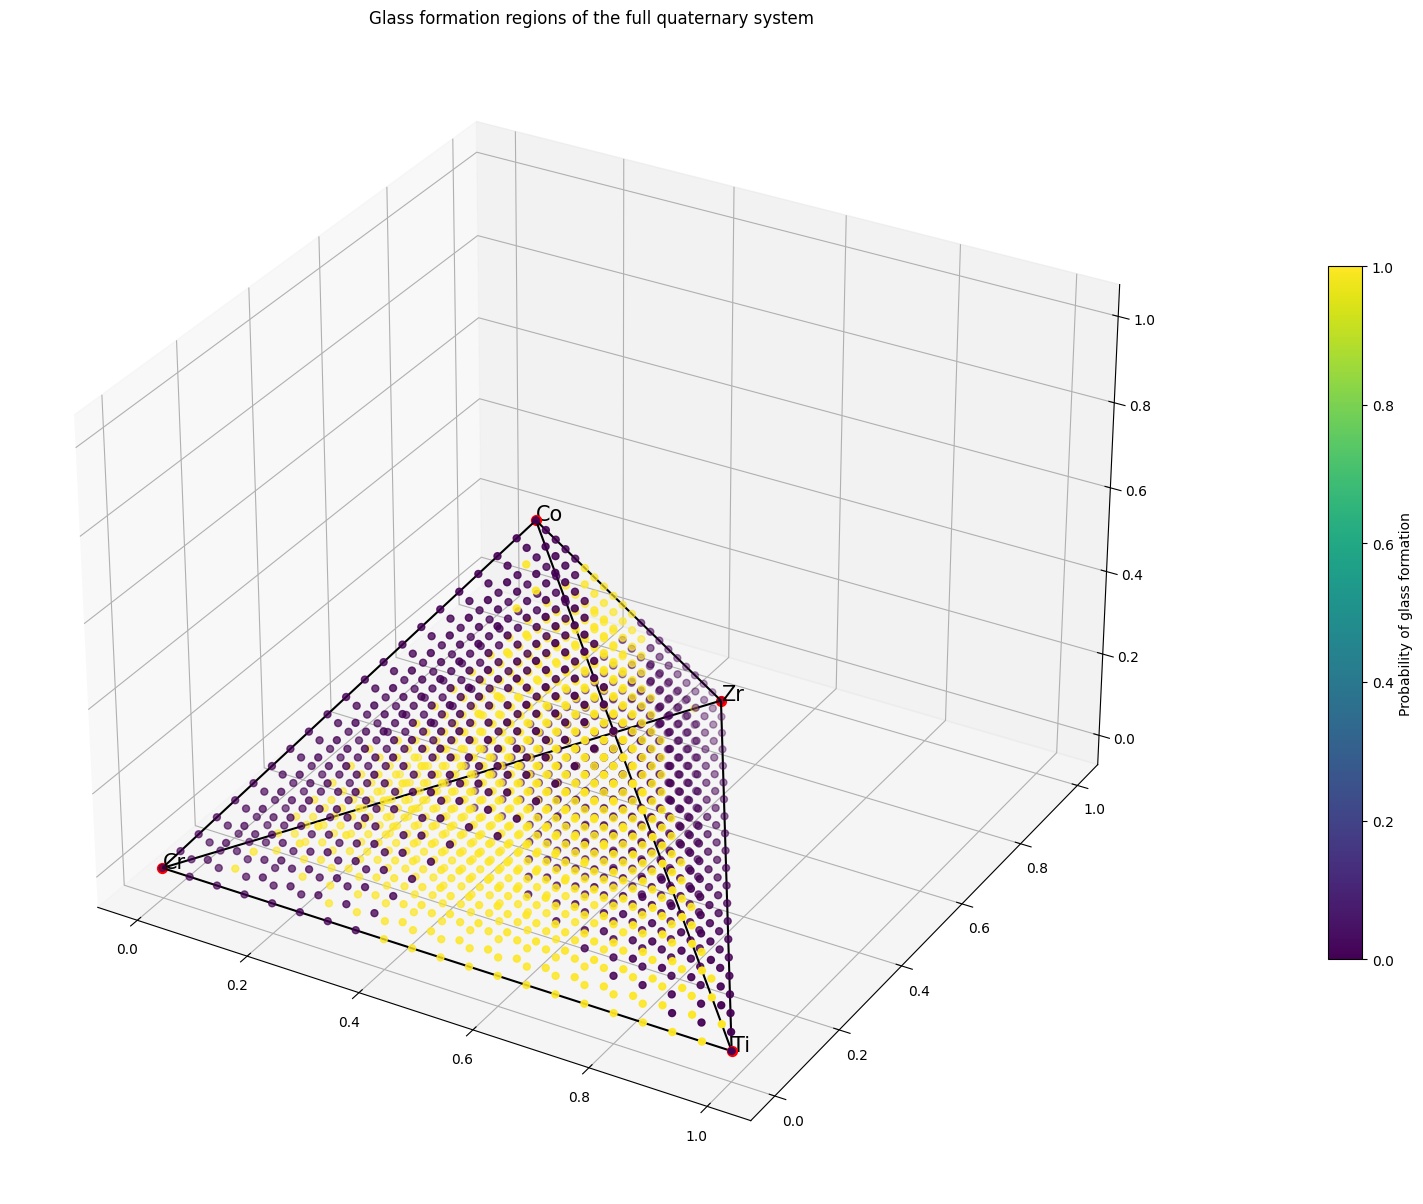

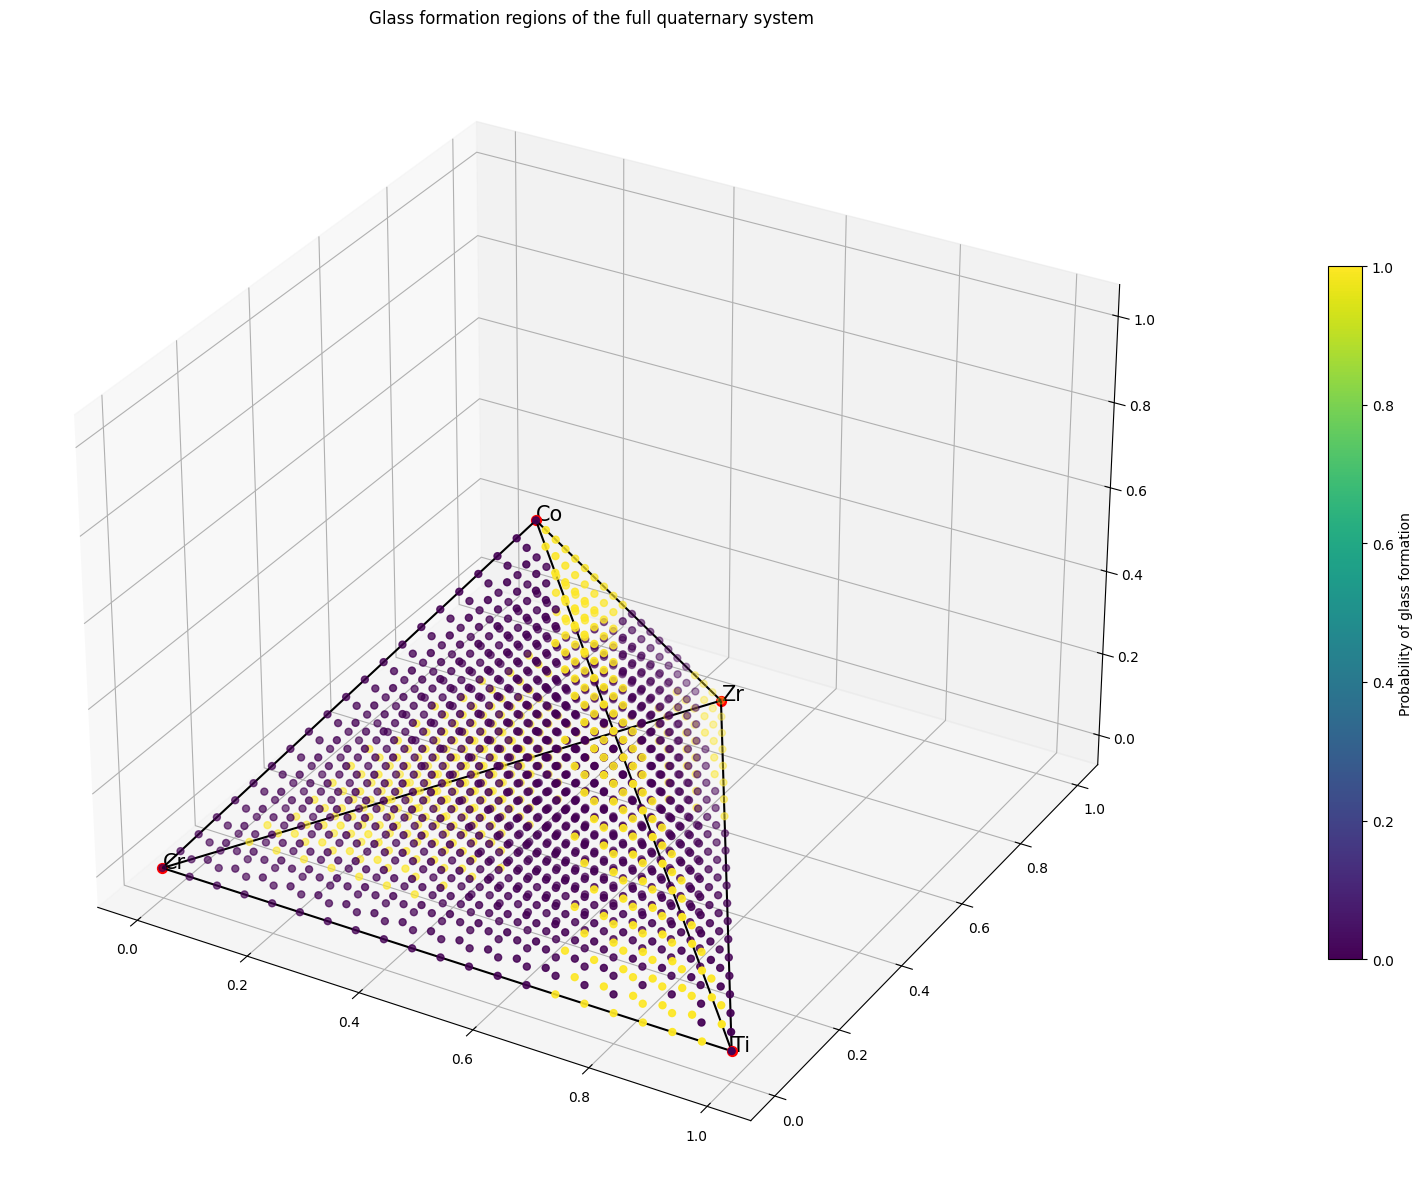

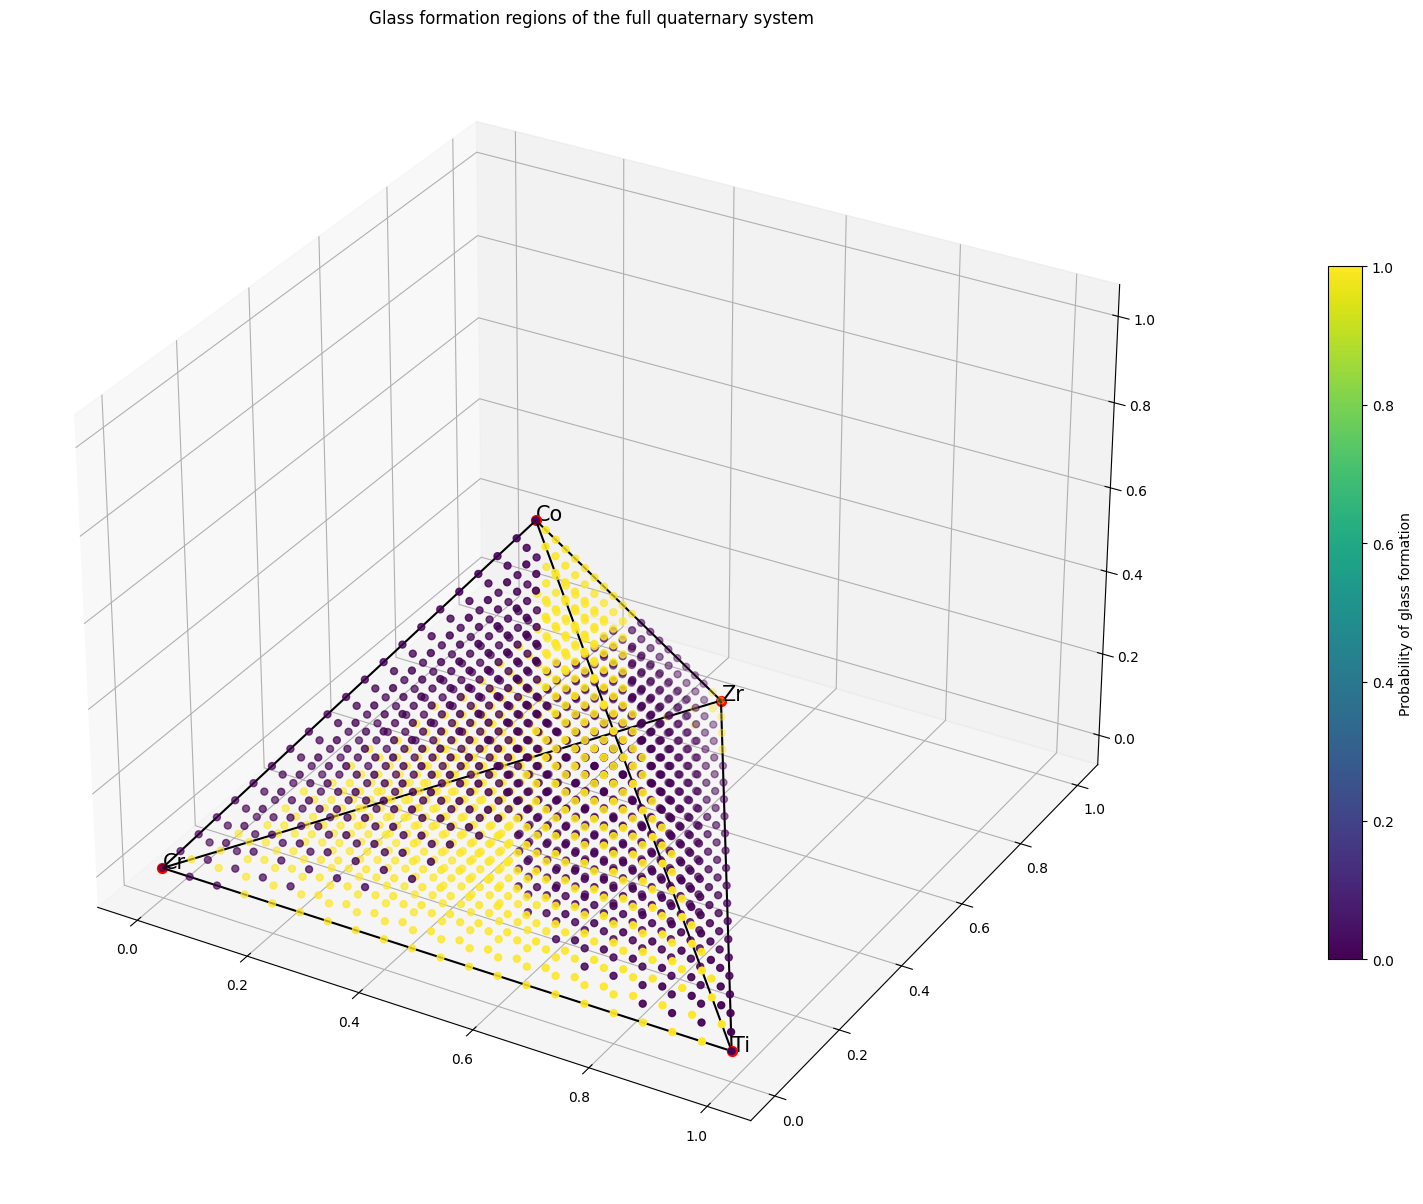

In [84]:
#plotting taken from GPT 3.5 and code from https://stackoverflow.com/questions/57467943/how-to-make-3d-4-variable-ternary-pyramid-plot-in-r-or-python
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import numpy as np

def project_to_3d_tetrahedron(coords_4d):
    # Define vertices of a 3D tetrahedron pyramid in the positive quadrant
    tetrahedron_vertices =[[0,0,0],
     [1,0,0],
     [0.5,np.sqrt(3)/2,0],
     [0.5,0.28867513, 0.81649658]]
    # Perspective projection matrix
    projection_matrix = [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ]
    # Project 4D coordinates to 3D using perspective projection
    t = np.transpose(np.array(tetrahedron_vertices))        
    t_array=np.array(t.dot(coords_4d)) #apply transform to all points
    return t_array

coors_3d_total = [project_to_3d_tetrahedron(x) for x in result_dataframe]
for prediction in full_model_predictions:
    # Create a 3D plot
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')

    tetrahedron_vertices =[[0,0,0],
        [1,0,0],
        [0.5,np.sqrt(3)/2,0],
        [0.5,0.28867513, 0.81649658]]

    # Plot the tetrahedron edges
    edges = [
        [tetrahedron_vertices[0], tetrahedron_vertices[1]],
        [tetrahedron_vertices[1], tetrahedron_vertices[2]],
        [tetrahedron_vertices[2], tetrahedron_vertices[0]],
        [tetrahedron_vertices[0], tetrahedron_vertices[3]],
        [tetrahedron_vertices[1], tetrahedron_vertices[3]],
        [tetrahedron_vertices[2], tetrahedron_vertices[3]]
    ]

    edge_collection = Line3DCollection(edges, colors='black')
    ax.add_collection3d(edge_collection)

    # Plot the tetrahedron vertices with labels
    for i, vertex in enumerate(tetrahedron_vertices):
        ax.scatter(*vertex, color='red', s=50, marker='o', label=f'{column_labels_final[i]}')
        ax.text(*vertex, f'{column_labels_final[i]}', fontsize=15)

    # Plot the projected points
    sc = ax.scatter(*zip(*coors_3d_total),s=25, marker='o',c=prediction, cmap='viridis')

    # Set labels and display the plot
    plt.colorbar(sc, ax=ax, pad=0.1,shrink= 0.45, label='Probability of glass formation')
    plt.title(f'Glass formation regions of the full quaternary system')
    plt.show()


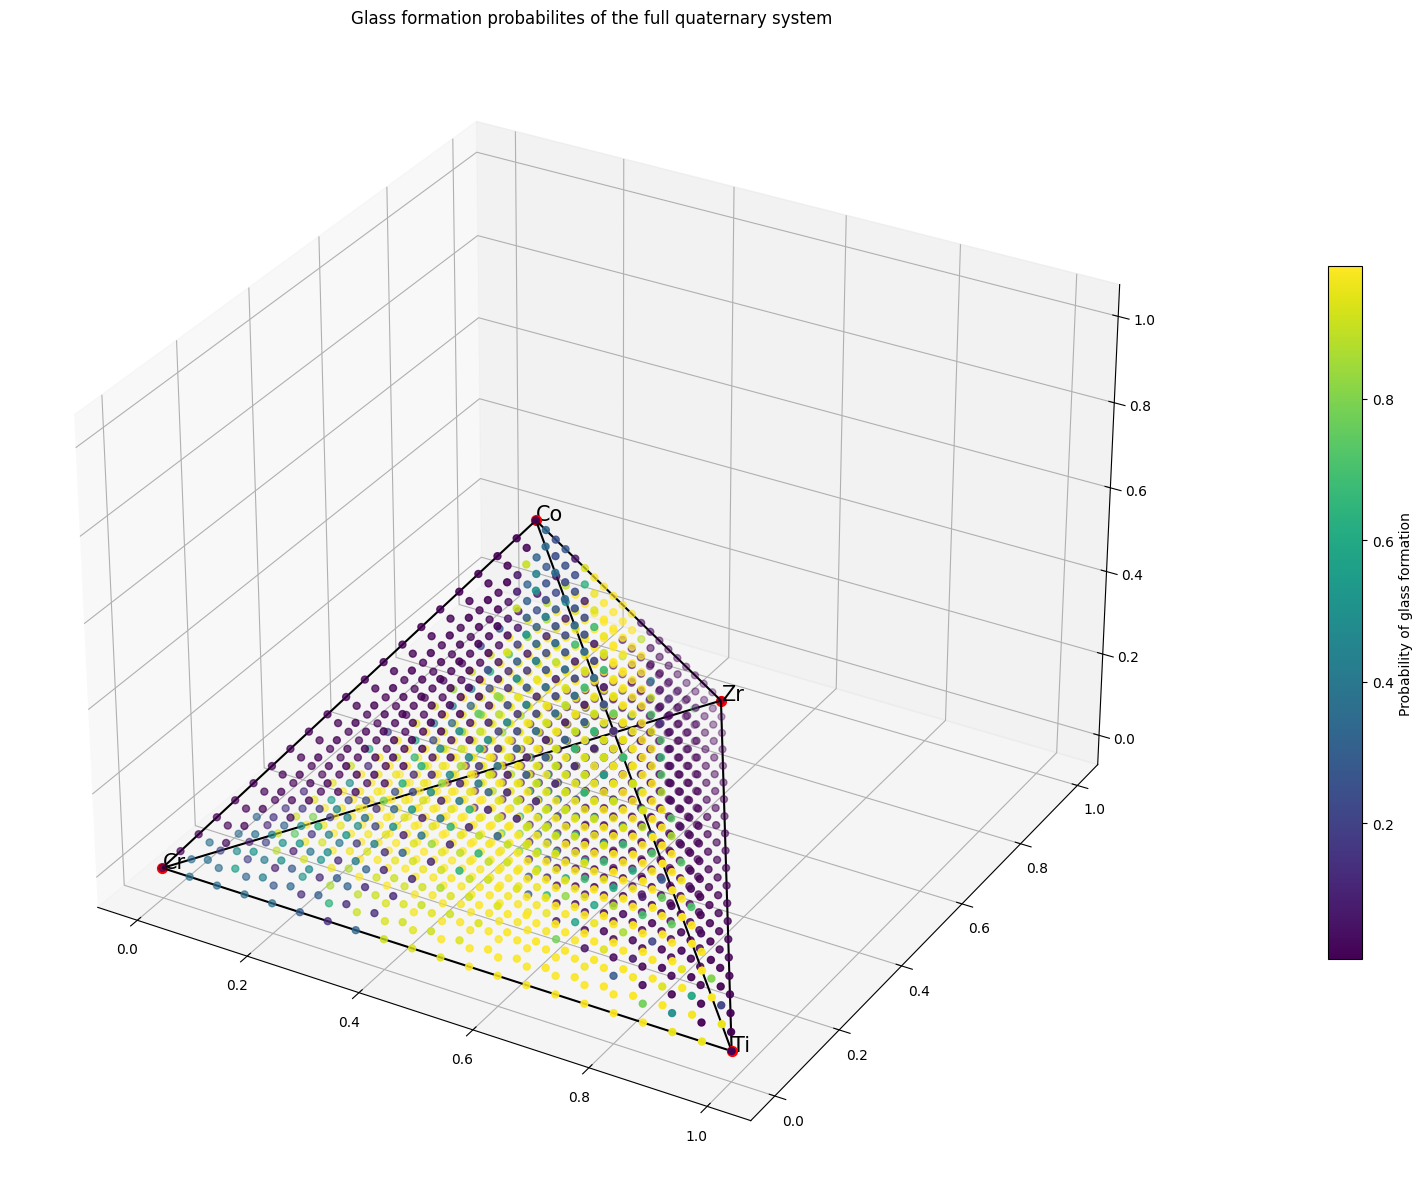

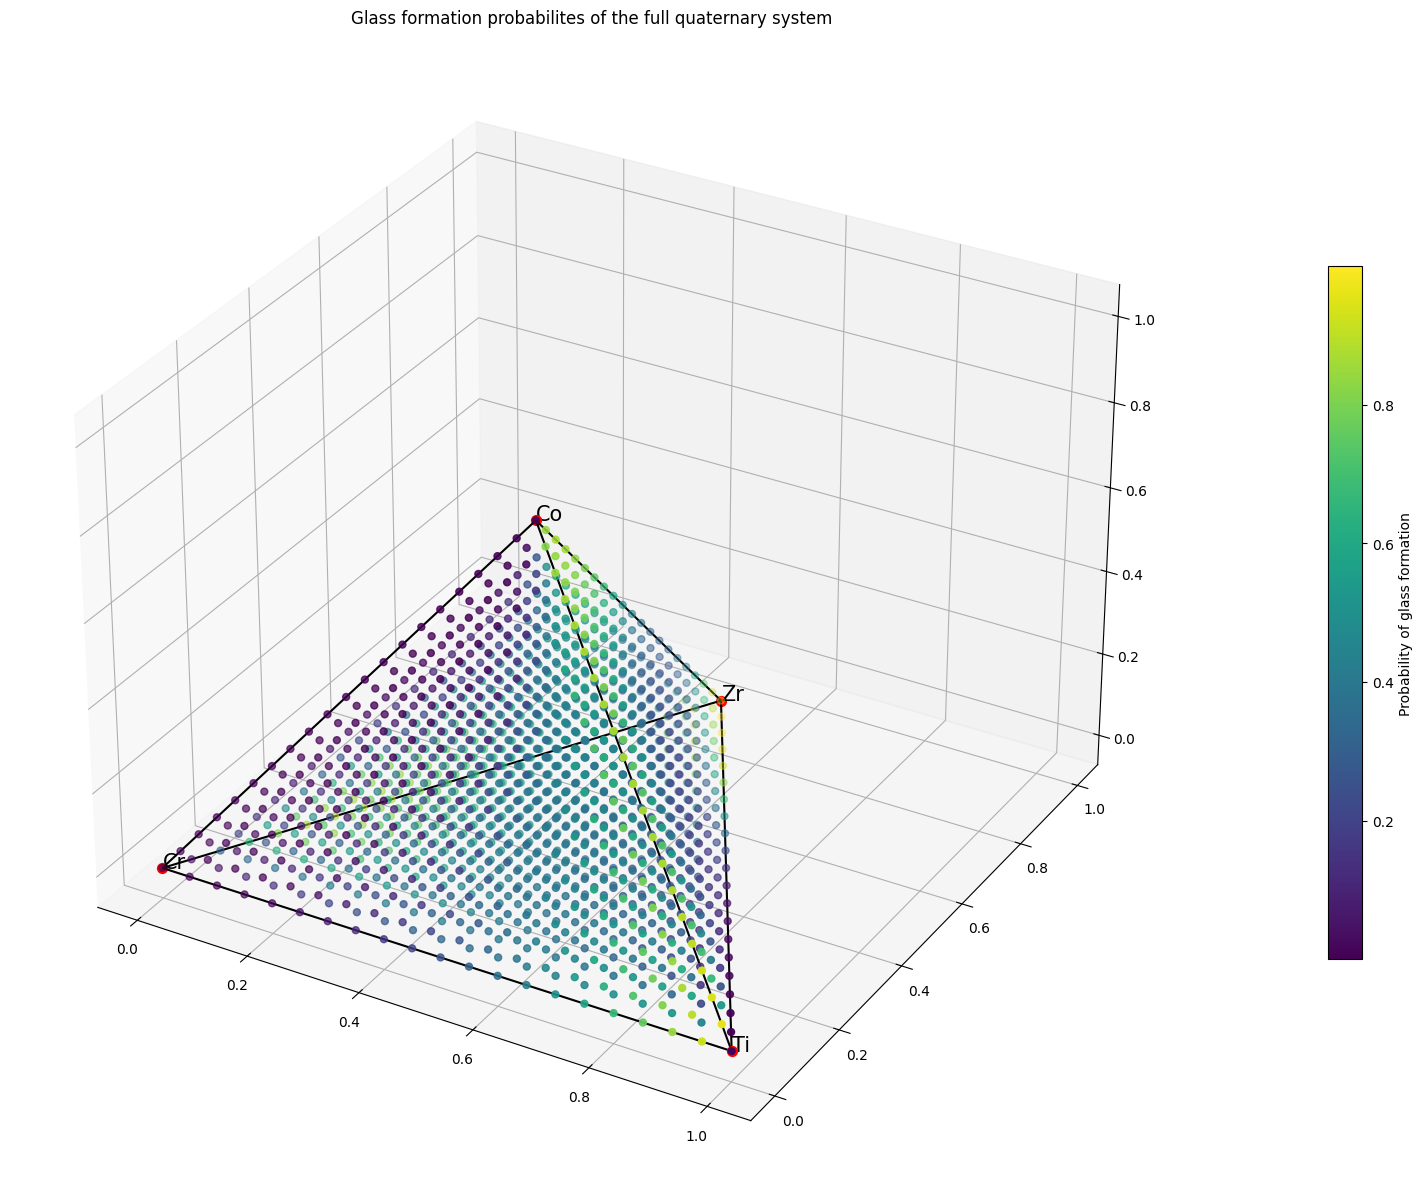

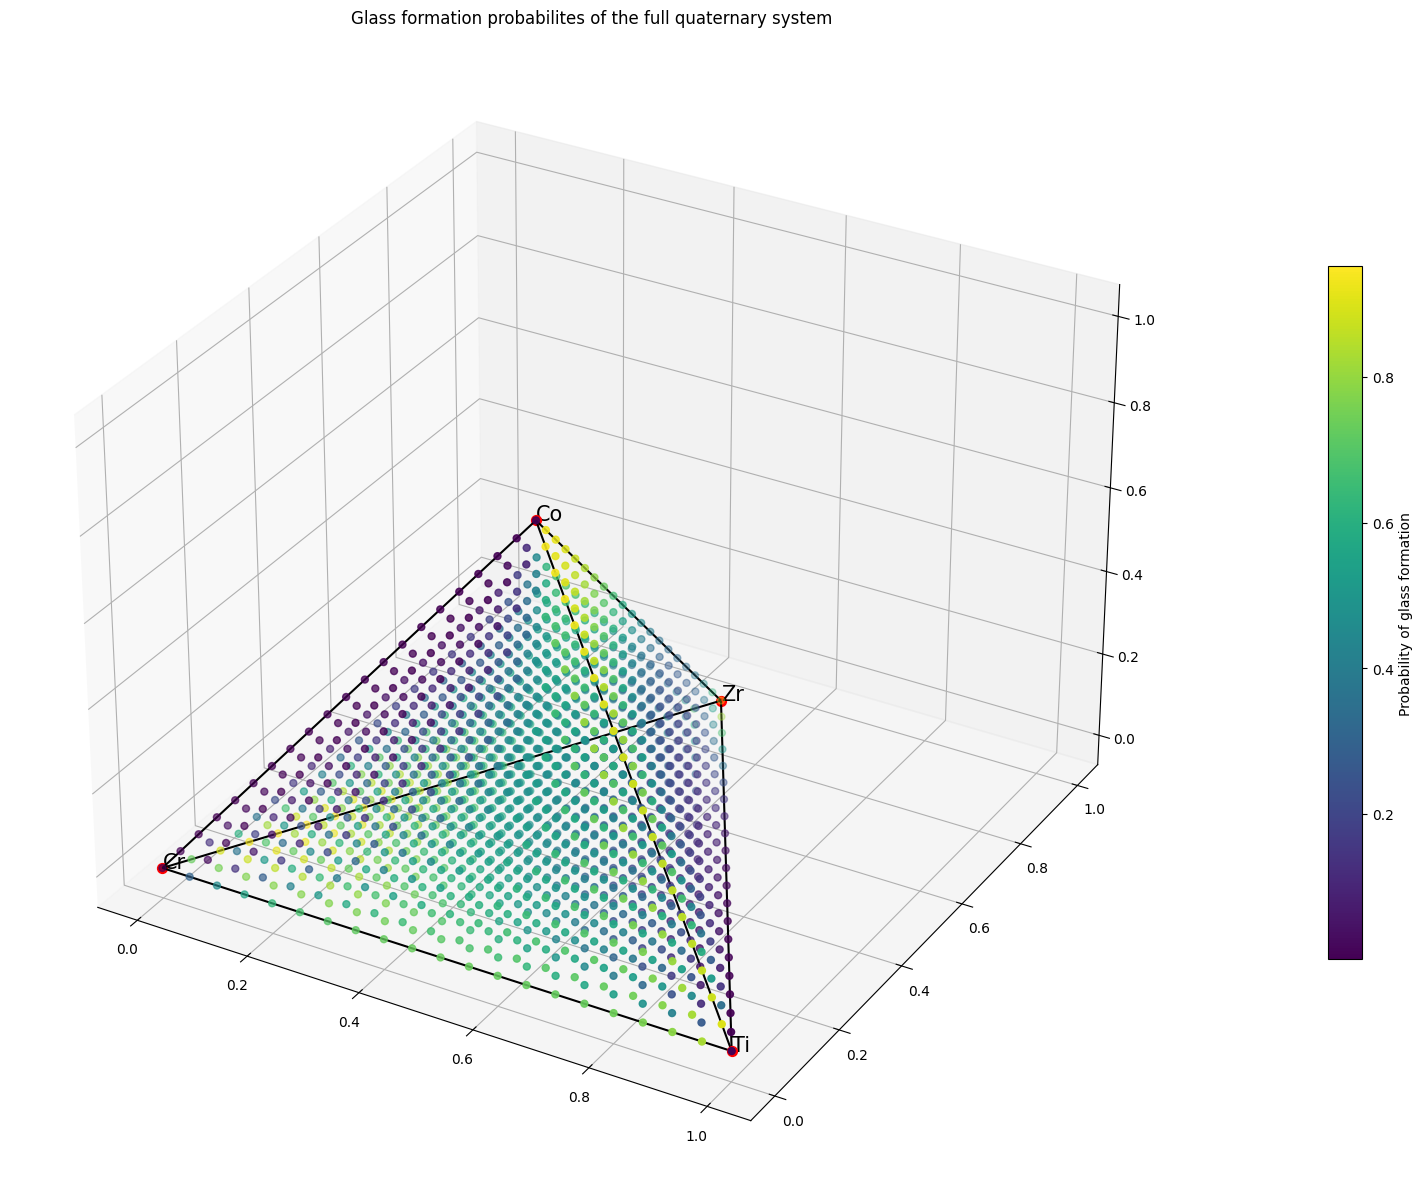

In [86]:
for prediction in full_model_predictions_probabilites:
    # Create a 3D plot
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')

    tetrahedron_vertices =[[0,0,0],
        [1,0,0],
        [0.5,np.sqrt(3)/2,0],
        [0.5,0.28867513, 0.81649658]]

    # Plot the tetrahedron edges
    edges = [
        [tetrahedron_vertices[0], tetrahedron_vertices[1]],
        [tetrahedron_vertices[1], tetrahedron_vertices[2]],
        [tetrahedron_vertices[2], tetrahedron_vertices[0]],
        [tetrahedron_vertices[0], tetrahedron_vertices[3]],
        [tetrahedron_vertices[1], tetrahedron_vertices[3]],
        [tetrahedron_vertices[2], tetrahedron_vertices[3]]
    ]

    edge_collection = Line3DCollection(edges, colors='black')
    ax.add_collection3d(edge_collection)

    # Plot the tetrahedron vertices with labels
    for i, vertex in enumerate(tetrahedron_vertices):
        ax.scatter(*vertex, color='red', s=50, marker='o', label=f'{column_labels_final[i]}')
        ax.text(*vertex, f'{column_labels_final[i]}', fontsize=15)

    # Plot the projected points
    sc = ax.scatter(*zip(*coors_3d_total),s=25, marker='o',c=prediction, cmap='viridis')

    # Set labels and display the plot
    plt.colorbar(sc, ax=ax, pad=0.1,shrink= 0.45, label='Probability of glass formation')
    plt.title(f'Glass formation probabilites of the full quaternary system')
    plt.show()

The model predictions show some regions it does not consider glass forming that could have glass forming capabilities.

<font size = 6>

**Yang Heuristic**


In [89]:
from matminer.featurizers.composition.alloy import YangSolidSolution
yang =  YangSolidSolution()
yang_df_system =yang.featurize_dataframe(Compositions,'composition',ignore_errors=True)
yang_df_og =yang.featurize_dataframe(comp_strings,'composition',ignore_errors=True)

YangSolidSolution:   0%|          | 0/1771 [00:00<?, ?it/s]

YangSolidSolution:   0%|          | 0/1323 [00:00<?, ?it/s]

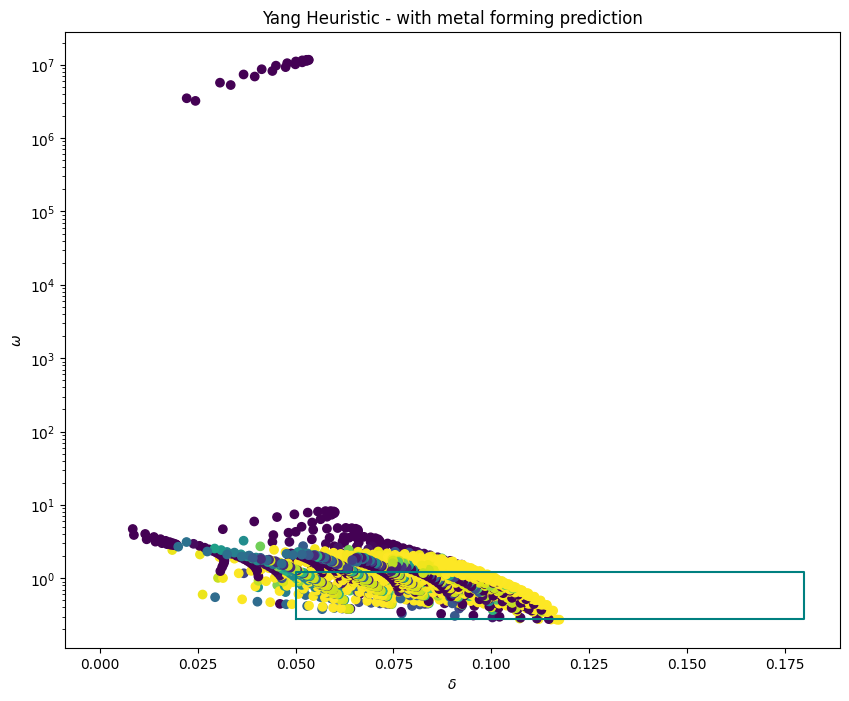

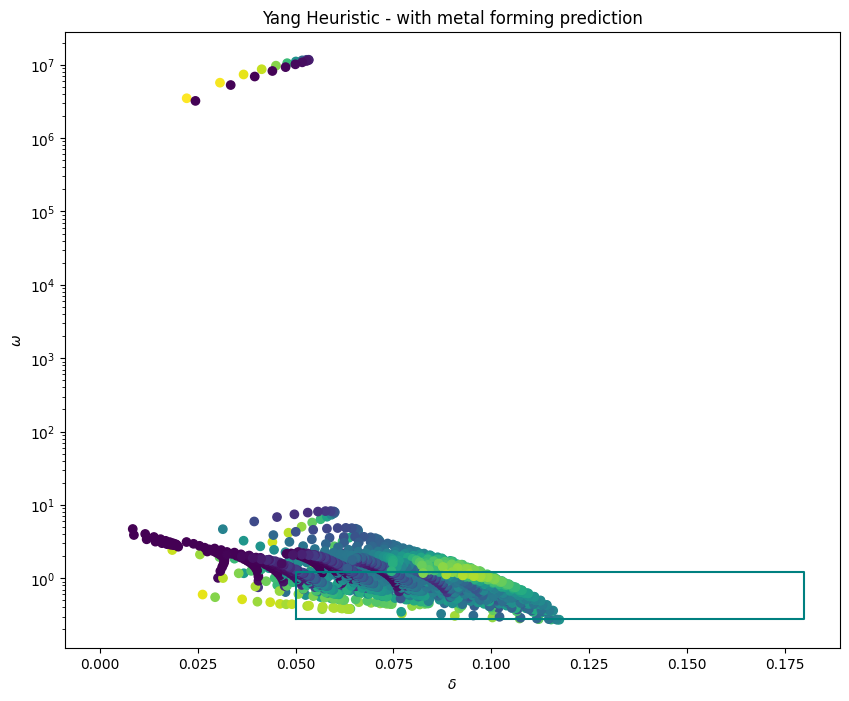

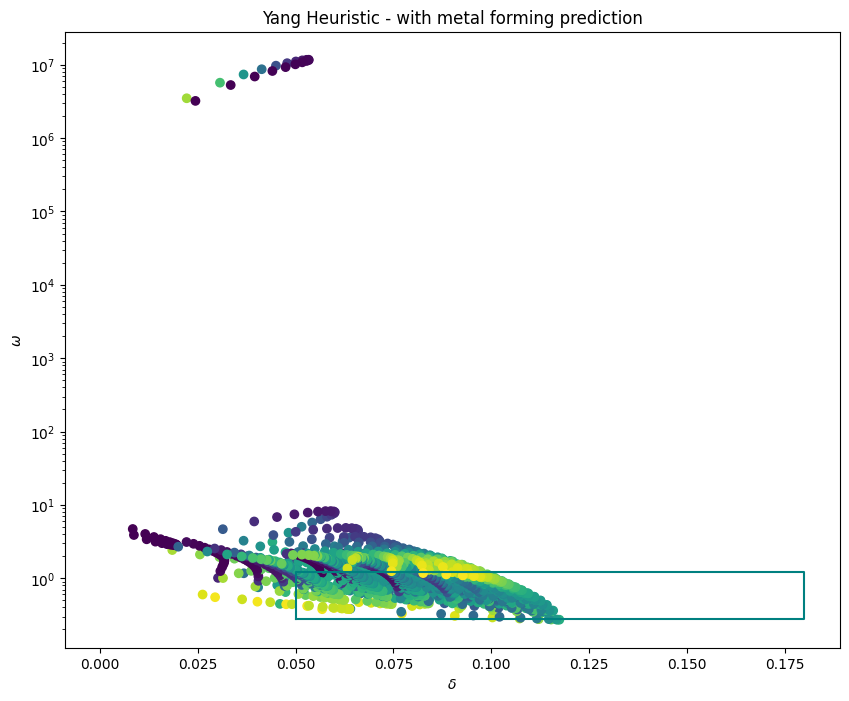

In [109]:
#taken from GPT3.5

#Getting X and Y avalues
deltas = yang_df_system['Yang delta'].values.tolist()
omegas = yang_df_system['Yang omega'].values.tolist()

for prediction in full_model_predictions_probabilites:
    #size
    plt.figure(figsize=(10, 8))
    
    # Plotting full heuristic
    plt.scatter(deltas, omegas, c=prediction, label='Non Glass')

    square_coords = [(0.05, 0.28), (0.05, 1.2), (0.18, 1.2), (0.18, 0.28), (0.05, 0.28)]

    # Extract x and y coordinates from the square_coords list
    square_x, square_y = zip(*square_coords)

    # Plot the square
    plt.plot(square_x, square_y, color='teal')
    #axes
    plt.xlabel(r'$\delta$')
    plt.ylabel(r'$\omega$')
    plt.title('Yang Heuristic - with metal forming prediction')
    plt.yscale('log')

    # Show the plot
    plt.show()


In [112]:
final_prediction_probability

[array([[0.93549975, 0.06450025],
        [0.98975769, 0.01024231],
        [0.97972755, 0.02027245],
        ...,
        [0.01355406, 0.98644594],
        [0.01355406, 0.98644594],
        [0.01355406, 0.98644594]]),
 array([[0.6018141 , 0.3981859 ],
        [0.84787201, 0.15212799],
        [0.7955519 , 0.2044481 ],
        ...,
        [0.04544807, 0.95455193],
        [0.04563479, 0.95436521],
        [0.0239337 , 0.9760663 ]]),
 array([[0.57680432, 0.42319568],
        [0.82016822, 0.17983178],
        [0.76627233, 0.23372767],
        ...,
        [0.07600728, 0.92399272],
        [0.07628239, 0.92371761],
        [0.04593957, 0.95406043]])]

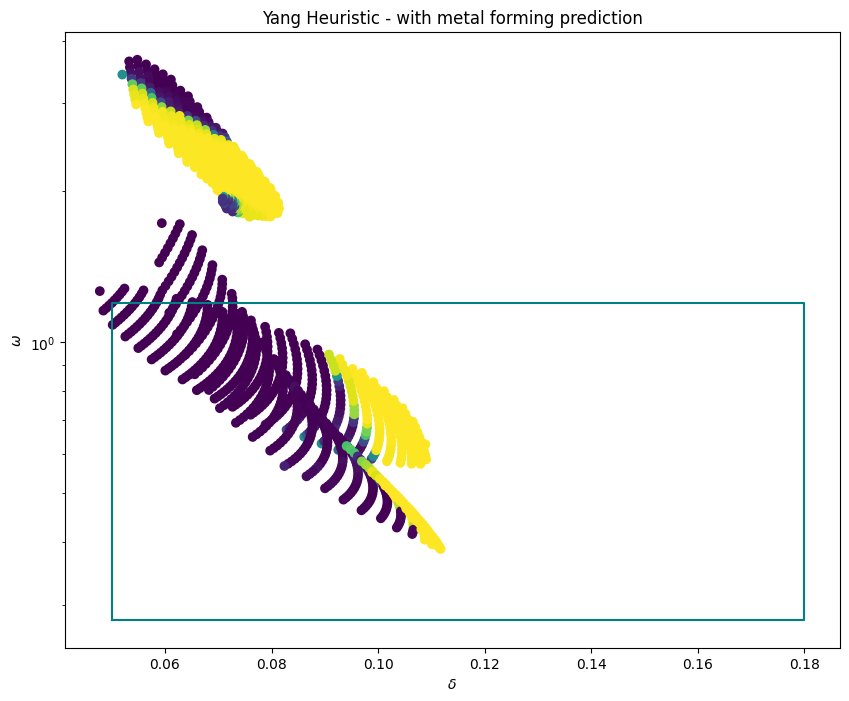

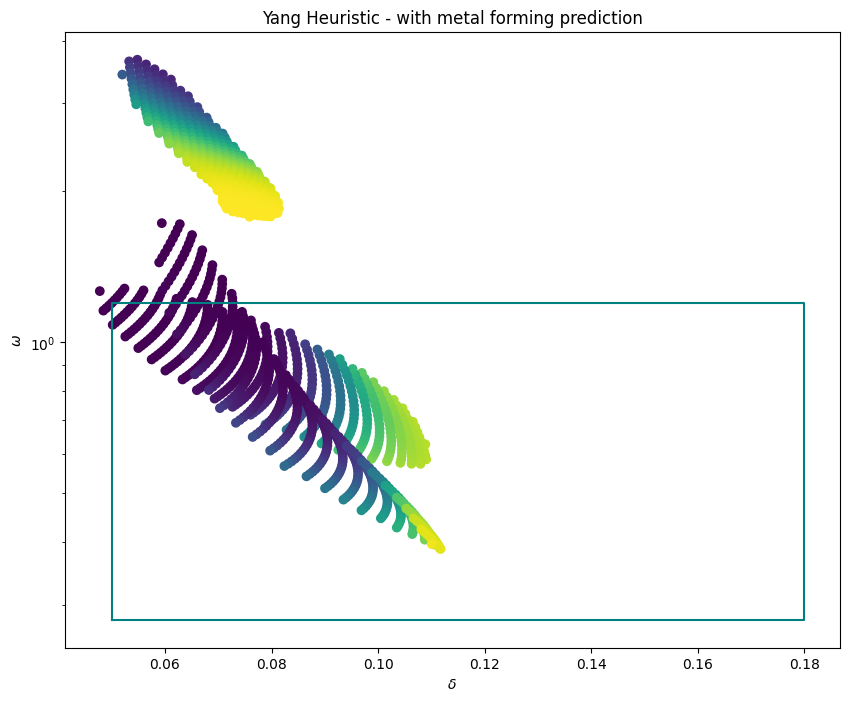

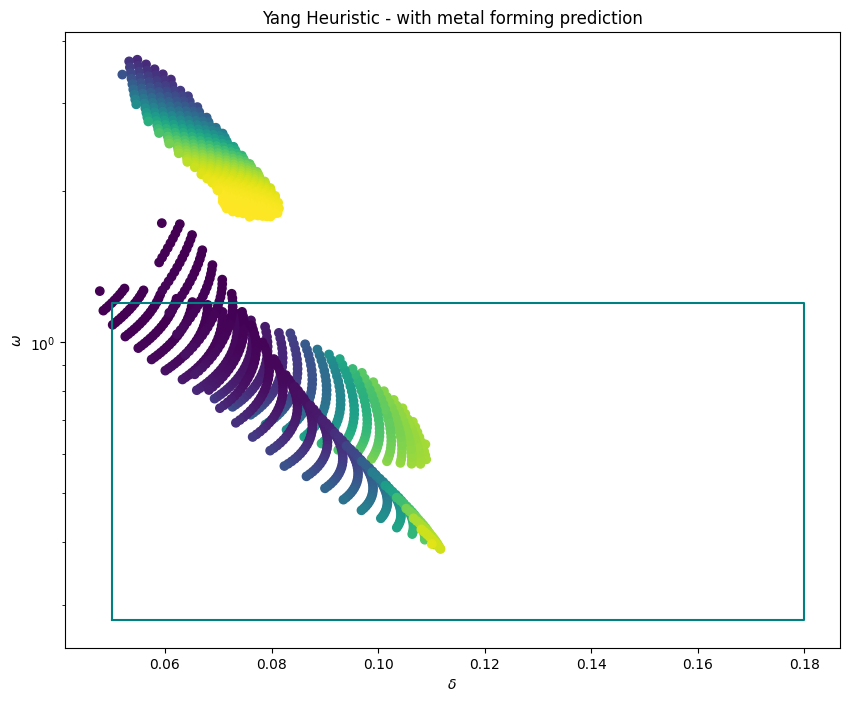

In [119]:

#Getting X and Y avalues
deltas = yang_df_og['Yang delta'].values.tolist()
omegas = yang_df_og['Yang omega'].values.tolist()

for prediction in final_prediction_probability:
    #size
    plt.figure(figsize=(10, 8))

    # Plotting full heuristic
    plt.scatter(deltas, omegas, c=prediction, label='Non Glass')

    square_coords = [(0.05, 0.28), (0.05, 1.2), (0.18, 1.2), (0.18, 0.28), (0.05, 0.28)]

    # Extract x and y coordinates from the square_coords list
    square_x, square_y = zip(*square_coords)

    # Plot the square
    plt.plot(square_x, square_y, color='teal')

    #axes
    plt.xlabel(r'$\delta$')
    plt.ylabel(r'$\omega$')
    plt.title('Yang Heuristic - with metal forming prediction')
    plt.yscale('log')

    # Show the plot
    plt.show()

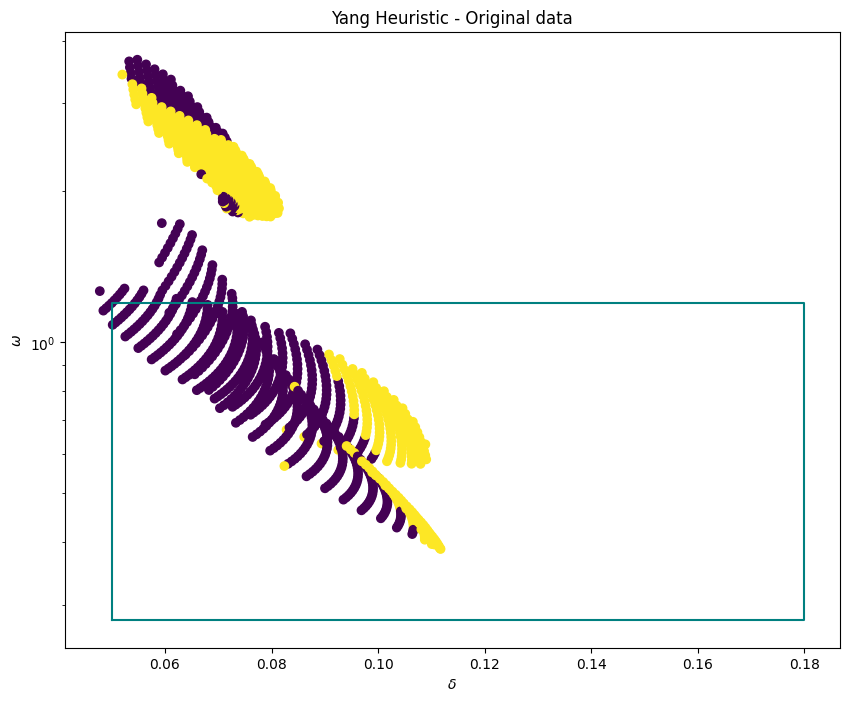

In [107]:
# Plotting full heuristic
plt.figure(figsize=(10, 8))
plt.scatter(deltas, omegas, c=target_values, label='Non Glass')

#axes
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\omega$')
plt.title('Yang Heuristic - Original data')
plt.yscale('log')

#Heuristic metallic region
# Define the coordinates of the square
square_coords = [(0.05, 0.28), (0.05, 1.2), (0.18, 1.2), (0.18, 0.28), (0.05, 0.28)]

# Extract x and y coordinates from the square_coords list
square_x, square_y = zip(*square_coords)

# Plot the square
plt.plot(square_x, square_y, color='teal')

# Show the plot
plt.show()

In [122]:
len(indexes_mg_yang)

811

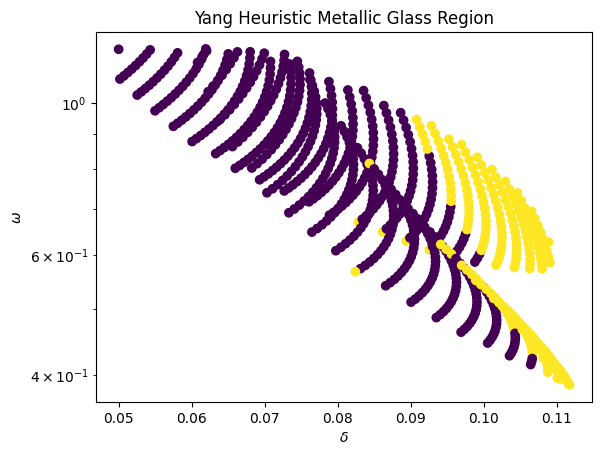

In [125]:
#plotting predictions inside the metallic glass region of the heuristic
mg_coordinates = []
indexes_mg_yang =[]
for i,j in enumerate(zip(deltas,omegas)):
    if (j[0]>=0.05) & (j[0]<=0.18):
        if (j[1]>=0.28) & (j[1]<=1.2):
            mg_coordinates.append((j[0],j[1]))
            indexes_mg_yang.append(i)

final_predictions_yang = [target_values[i] for i in indexes_mg_yang]
plt.scatter(*zip(*mg_coordinates),c=final_predictions_yang)
#axes
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\omega$')
plt.title('Yang Heuristic Metallic Glass Region')
plt.yscale('log')

# Show the plot
plt.show()

In [128]:
print(f'{sum(final_predictions_yang)} were considered glass out of {len(final_predictions_yang)}')

222 were considered glass out of 811


<font size = 5> **Summary**

The feature selection process successfully identified a concise list of influential features that align with established literature on critical factors governing metallic glass formation, primarily rooted in thermodynamic principles. The model exhibited a high level of accuracy in fitting the data, albeit displaying signs of overfitting. This phenomenon can be attributed to the specific objective function utilized for classification. To enhance the model's performance, future endeavors could focus on integrating additional featurizers and engineered features, alongside refining the classifier to adopt a statistical framework rather than decision trees, as observed with LGBM, which led to pronounced overfitting when trained on the entire dataset.

The delineation of regions within the quaternary system was not well-defined, lacking clear borders when visualized in three dimensions. Comparative analysis against the Yang heuristic graph revealed moderate success in predicting certain instances of glass formation within the system, achieving an approximate accuracy of 66% in discerning the likelihood of metallic glass occurrence in specific regions. As mentioned earlier, modifications in the feature and model selection workflows hold promise for enhancing predictive capabilities in this domain.

<font size = 5> **References:**</font>
<br>
<br>
[1]  M. E. McHenry and D. E. Laughlin, "Magnetic Properties of Metals and Alloys," in Physical Metallurgy, Elsevier, 2014.
<br>
[2]  A High-Throughput Structural and Electrochemical Study of Metallic Glass Formation in Ni–Ti–Al
Howie Joress, Brian L. DeCost, Suchismita Sarker, Trevor M. Braun, Sidra Jilani, Ryan Smith, Logan Ward, Kevin J. Laws, Apurva Mehta, and Jason R. Hattrick-Simpers
ACS Combinatorial Science 2020 22 (7), 330-338
<br>
[3]  Automatic Prediction of Band Gaps of Inorganic Materials Using a Gradient Boosted and Statistical Feature Selection Workflow
Son Gyo Jung, Guwon Jung, and Jacqueline M. Cole
Journal of Chemical Information and Modeling 2024 64 (4), 1187-1200
DOI: 10.1021/acs.jcim.3c01897 
<br>
[4]  Yang, X.; Zhang, Y. Prediction of high-entropy stabilized solidsolution
in multi-component alloys. Mater. Chem. Phys. 2012, 132,
233−238.
<br>
[5]  Gradient boosted and statistical feature selection workflow for materials property predictions
Jung, Son Gyo; Jung, Guwon; Cole, Jacqueline M.
Journal of Chemical Physics (2023), 159 (19), 194106CODEN: JCPSA6; ISSN:0021-9606. (American Institute of Physics) 